## 🩺 👩🏼‍⚕️ 👨🏼‍⚕️ Machine learning classifiers for predicting no-show appointments 👩🏼‍💼 👨🏼‍💼

This is a notebook to test different classifiers on the dataset from Kaggle (noshowappointments). The goal is to predict whether a patient will show up for an appointment or not.
The notebook goal is to create the best classifier possible, and to compare the results of different classifiers. Also, explainable methods are employed to understand the results of the classifiers as the classifiers are used in a medical context. The classifiers developed are not explained by their structure.

The classifiers are tested on the dataset from Kaggle (noshowappointments). The dataset contains information about 110527 medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row. The dataset is available at https://www.kaggle.com/joniarroba/noshowappointments.

The dataset has been cleaned and preprocessed in the notebook "eda-prep.ipynb". The cleaned dataset is saved in the file "cleaned_data.csv".

***

The following models are trained and tested:

1. XGBoost

XGBoost stands for eXtreme Gradient Boosting. 
XGBoost is an implementation of gradient boosted trees designed for speed and performance that is dominative competitive machine learning.

https://xgboost.readthedocs.io/en/latest/

2. Random Forest

Random Forest is an ensemble learning method, in this notebook it is used as a classifier. 
The method is based on decision trees and is based on the idea that a large number of relatively uncorrelated models (trees) operating as a committee will outperform any of the individual constituent models.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

3. Gradient Boosting

Gradient Boosting is an ensemble learning approach which produces an additive model in a forward stage-wise fashion.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

4. AdaBoost

> AdaBoost classfier is a meta-estimator that begins by fitting a classifier on the > original dataset and then fits additional copies of the classifier on the same dataset > but where the weights of incorrectly classified instances are adjusted such that > subsequent classifiers focus more on difficult cases.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

***

The following methods are used to explain the results of the classifiers:
- Feature importance

Feature importance is derived from the feature_importances_ attribute of the classifier when fitted.

- PDPs (Partial Dependence Plots)

> The partial dependence plot (short PDP or PD plot) shows the marginal effect one or > two features have on the predicted outcome of a machine learning model (J. H. > Friedman 2001).

- ICE (Individual Conditional Expectation)

> The ICE plot shows the dependence between the target function and a feature of interest. ICE plots visualize the dependence of the prediction on a feature fo each sample separately with one line per sample. 

https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#partial-dependence-and-individual-conditional-expectation-plots

- LIME (Local Interpretable Model-agnostic Explanations)

The LIME method is used to explain the predictions of the model.
It approximates the model locally within a small region around the instance to be explained. 
The new model is trained based on perturbated training data.
For numerical features, the perturbated data means from given data environment and predicion of its classification based on black-box model.
On this trening data, the interpretable model is trained.
The interpretability feature is used of the trained model in order to analyze the impact of parameters on the classification.

https://github.com/marcotcr/lime

https://arxiv.org/pdf/1602.04938.pdf

- SHAP (SHapley Additive exPlanations)

For each parameter, the Shapley value is calculated through building coalitions of parameters and calculating the impact of the parameter on the classification.

https://github.com/slundberg/shap

http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

***

### 🗃 Import libraries

In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from sklearn.inspection import PartialDependenceDisplay

from imblearn.under_sampling import InstanceHardnessThreshold

from interpret.blackbox import LimeTabular
from interpret import show
import shap

from yellowbrick.model_selection import FeatureImportances

import wandb

import pickle

In [ ]:
!git clone https://github.com/SauceCat/PDPbox.git
%cd PDPbox
!python setup.py install

In [2]:
import pdpbox
from pdpbox import pdp

### 🗂 Prepare data (data split, deal with imbalanced data)

#### Using DataLoader

In [21]:
class DataLoader():
    def __init__(self, dataset_path):
        self.data = pd.read_csv(dataset_path)

    def preprocess_data(self):
        # kodowanie danych kategorycznych metodą one-hot
        categorical_cols = [
            'Gender',
            'Neighbourhood',
            'AppointmentDayOfWeek',
            'ScheduledDayOfWeek',
            'AgeGroup',
            'AwaitingTimeGroup',
        ]
            
        encoded = pd.get_dummies(self.data[categorical_cols], 
                                prefix=categorical_cols)

        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

    def iht(self, X, y):
        iht = InstanceHardnessThreshold(random_state=2021)
        X, y = iht.fit_resample(X, y)
        return X, y
    
    def get_data_split(self):
        X = self.data.drop(['Show'], axis=1)
        y = self.data['Show']
        X, y = self.iht(X, y)
        return train_test_split(X, y, test_size=0.20, random_state=2021)
    

data_loader = DataLoader("../data/cleaned_data_with_categories.csv")
data_loader.preprocess_data()
X_train, X_test, y_train, y_test = data_loader.get_data_split()
X_train, y_train = data_loader.iht(X_train, y_train)


print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


Train data shape: (35703, 116)
Test data shape: (8926, 116)


#### Without DataLoader

In [9]:
df = pd.read_csv('../data/cleaned_data_final.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110521 entries, 0 to 110520
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Gender                110521 non-null  int64
 1   Scholarship           110521 non-null  int64
 2   Hypertension          110521 non-null  int64
 3   Diabetes              110521 non-null  int64
 4   Alcoholism            110521 non-null  int64
 5   Handicap              110521 non-null  int64
 6   SMS_received          110521 non-null  int64
 7   Show                  110521 non-null  int64
 8   ScheduledHour         110521 non-null  int64
 9   ScheduledMonth        110521 non-null  int64
 10  AppointmentMonth      110521 non-null  int64
 11  ScheduledDayOfWeek    110521 non-null  int64
 12  AppointmentDayOfWeek  110521 non-null  int64
 13  AgeGroupInt           110521 non-null  int64
 14  NeighbourhoodInt      110521 non-null  int64
 15  AwaitingTimeGroup     110521 non-n

In [10]:
X = df.drop(['Show'], axis=1)
y = df['Show']

In [11]:
print('Original dataset shape %s' % Counter(y))

Original dataset shape Counter({1: 88207, 0: 22314})


##### ⚖️ IHT for imbalanced data

This approach is inspired by the paper Batool, Tasneem, et al. "Predicting hospital no-shows using machine learning." 2020 IEEE International Conference on Internet of Things and Intelligence System (IoTaIS). IEEE, 2021.

In [12]:
iht = InstanceHardnessThreshold(random_state=42)
X_res, y_res = iht.fit_resample(X, y)

In [13]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 22525, 0: 22314})


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [15]:
print('X_train size: ', X_train.shape)
print('X_test size: ', X_test.shape)
print('y_train size: ', y_train.shape)
print('y_test size: ', y_test.shape)

X_train size:  (31387, 15)
X_test size:  (13452, 15)
y_train size:  (31387,)
y_test size:  (13452,)


In [16]:
print('y_train value counts: ', y_train.value_counts())
print('y_test value counts: ', y_test.value_counts())

y_train value counts:  1    15818
0    15569
Name: Show, dtype: int64
y_test value counts:  0    6745
1    6707
Name: Show, dtype: int64


###  📊 W&B for logging

In [17]:
WANDB_PROJECT_NAME = "mappshow-hp-optimize-final"

### ⚡️ XGBoost

#### Hyperparameter tuning

In [20]:
sweep_config_xgboost = {
    'name': 'XGBoost classifier',
    'method': 'bayes',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'booster': {
            'values': ['gbtree', 'gblinear']
        },
        'n_estimators': {
            'distribution': 'int_uniform',
            'min': 100,
            'max': 1000
        },
        'learning_rate': {
            'distribution': 'uniform',
            'min': 0.01,
            'max': 0.5
        },
        'max_depth': {
            'distribution': 'int_uniform',
            'min': 3,
            'max': 10
        },
        'min_child_weight': {
            'distribution': 'int_uniform',
            'min': 1,
            'max': 10
        },
        'gamma': {
            'distribution': 'uniform',
            'min': 0,
            'max': 0.5
        }
    }
}


def train_xgboost():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config
    
    xgboost_cls = XGBClassifier(
        booster=config.booster,
        n_estimators=config.n_estimators,
        learning_rate=config.learning_rate,
        max_depth=config.max_depth,
        min_child_weight=config.min_child_weight,
        gamma=config.gamma,
        objective='binary:logistic',
        seed=27
    )

    xgboost_cls.fit(X_train, y_train)

    y_pred = xgboost_cls.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    wandb.log({'accuracy': accuracy, 'f1': f1})


In [21]:
sweep_id_xgboost = wandb.sweep(sweep_config_xgboost, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id_xgboost, train_xgboost, count=30)

Create sweep with ID: ubhcxg6b
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize-final/sweeps/ubhcxg6b


wandb: Agent Starting Run: deisawgr with config:
wandb: 	booster: gblinear
wandb: 	gamma: 0.45604731457730785
wandb: 	learning_rate: 0.1558341052958276
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 836
wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[19:19:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.



wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y61cr93w with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.07082339313386976
wandb: 	learning_rate: 0.40580859747863435
wandb: 	max_depth: 5
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 882
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: ncgsxqgd with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.4148299748570765
wandb: 	learning_rate: 0.12943214979879472
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 839
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: m03yi68u with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.451900042038682
wandb: 	learning_rate: 0.01560190128089515
wandb: 	max_depth: 9
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 371
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: kag22uds with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.2647888766825191
wandb: 	learning_rate: 0.197361556753975
wandb: 	max_depth: 7
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 860
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: ko3qvcbu with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.3212825222683352
wandb: 	learning_rate: 0.2842799618269745
wandb: 	max_depth: 9
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 792
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tmkta6qj with config:
wandb: 	booster: gblinear
wandb: 	gamma: 0.36223785786984014
wandb: 	learning_rate: 0.21931233300461947
wandb: 	max_depth: 9
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 889
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[19:24:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.



wandb: Agent Starting Run: 5n53ci44 with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.30148679316415433
wandb: 	learning_rate: 0.33300887005673185
wandb: 	max_depth: 9
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 974
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: zs4wdfv1 with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.19268709098332
wandb: 	learning_rate: 0.18407853283953907
wandb: 	max_depth: 9
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 887
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: ebr8l662 with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.24979373762997392
wandb: 	learning_rate: 0.2538155327617117
wandb: 	max_depth: 10
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 721
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: q0w3mxc6 with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.21329676430440764
wandb: 	learning_rate: 0.35806049656597666
wandb: 	max_depth: 9
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 807
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 9nc8fnjl with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.3687129796212529
wandb: 	learning_rate: 0.2759364379707067
wandb: 	max_depth: 10
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 955
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0lla3784 with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.29980534271437265
wandb: 	learning_rate: 0.3436106870143593
wandb: 	max_depth: 10
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 868
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: brh319bf with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.23786289309167968
wandb: 	learning_rate: 0.1894458809520149
wandb: 	max_depth: 10
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 749
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 6y0oewsy with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.32760025368849954
wandb: 	learning_rate: 0.21830152521289856
wandb: 	max_depth: 10
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 814
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mdp3zwob with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.3772187026471016
wandb: 	learning_rate: 0.23741168901939896
wandb: 	max_depth: 10
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 975
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 94kqxlps with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.43175127235160016
wandb: 	learning_rate: 0.33181104086272006
wandb: 	max_depth: 10
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 903
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: pe0ke5rz with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.289289907390986
wandb: 	learning_rate: 0.26306030412207476
wandb: 	max_depth: 10
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 862
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: orbvhves with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.3985941712712478
wandb: 	learning_rate: 0.29071035021891
wandb: 	max_depth: 9
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 938
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 5xvfsvd8 with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.3774394958269463
wandb: 	learning_rate: 0.15045431323982597
wandb: 	max_depth: 9
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 885
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9t4s0l8u with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.37526625095712773
wandb: 	learning_rate: 0.09701609394241026
wandb: 	max_depth: 10
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 748
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: he5rqq8k with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.2137681573087852
wandb: 	learning_rate: 0.209458409472286
wandb: 	max_depth: 9
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 877
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: bemejmnm with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.1912391586817443
wandb: 	learning_rate: 0.07670981770362507
wandb: 	max_depth: 10
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 889
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: btabve3u with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.2812212133181364
wandb: 	learning_rate: 0.28840449444966865
wandb: 	max_depth: 9
wandb: 	min_child_weight: 5
wandb: 	n_estimators: 975
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: wkx371bm with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.3270999420020273
wandb: 	learning_rate: 0.30320849144588546
wandb: 	max_depth: 10
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 927
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 0qshvawl with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.33850953806035833
wandb: 	learning_rate: 0.2065691726518658
wandb: 	max_depth: 10
wandb: 	min_child_weight: 3
wandb: 	n_estimators: 1000
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 8e981xse with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.33027313754162396
wandb: 	learning_rate: 0.209495895134807
wandb: 	max_depth: 9
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 871
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: ad90qmk8 with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.33260648573517054
wandb: 	learning_rate: 0.3073625779047612
wandb: 	max_depth: 10
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 898
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jo9w9o0l with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.3724069179118836
wandb: 	learning_rate: 0.28072078320432287
wandb: 	max_depth: 10
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 901
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: owlclhbu with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.22300548874266063
wandb: 	learning_rate: 0.12304395786731978
wandb: 	max_depth: 10
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 802
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


In [31]:
sweep_id_xgboost = wandb.sweep(sweep_config_xgboost, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id_xgboost, train_xgboost, count=30)

Create sweep with ID: s5nw47o9
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize/sweeps/s5nw47o9


wandb: Agent Starting Run: tteigti1 with config:
wandb: 	booster: dart
wandb: 	gamma: 0.4631936704336765
wandb: 	learning_rate: 0.11168464597791376
wandb: 	max_depth: 6
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 599
wandb: Currently logged in as: polejowska. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 92tnax2z with config:
wandb: 	booster: gblinear
wandb: 	gamma: 0.017055877785432216
wandb: 	learning_rate: 0.1798154512637863
wandb: 	max_depth: 3
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 950
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[18:15:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.



wandb: Agent Starting Run: fazhvx4y with config:
wandb: 	booster: gblinear
wandb: 	gamma: 0.42990212738596034
wandb: 	learning_rate: 0.08004195438040837
wandb: 	max_depth: 8
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 477
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


[18:15:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "gamma", "max_depth", "min_child_weight" } are not used.



wandb: Agent Starting Run: elgybu3h with config:
wandb: 	booster: dart
wandb: 	gamma: 0.4619081542897248
wandb: 	learning_rate: 0.15678661675483724
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 493
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u2iqwb7i with config:
wandb: 	booster: dart
wandb: 	gamma: 0.4708257952804661
wandb: 	learning_rate: 0.21486919861755385
wandb: 	max_depth: 6
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 769
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: eq15jsgz with config:
wandb: 	booster: dart
wandb: 	gamma: 0.4921102946969505
wandb: 	learning_rate: 0.07130369583665831
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 825
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: se2jtcsi with config:
wandb: 	booster: dart
wandb: 	gamma: 0.4910318738854631
wandb: 	learning_rate: 0.23166563651738745
wandb: 	max_depth: 3
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 265
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 231c02ky with config:
wandb: 	booster: dart
wandb: 	gamma: 0.4842279958573853
wandb: 	learning_rate: 0.48728342084922416
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 242
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 19ule82z with config:
wandb: 	booster: dart
wandb: 	gamma: 0.3629893403377599
wandb: 	learning_rate: 0.40488691500265733
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 173
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: x2g76p7c with config:
wandb: 	booster: gbtree
wandb: 	gamma: 0.4889319577521547
wandb: 	learning_rate: 0.473646433765462
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 161
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: v5jq1f48 with config:
wandb: 	booster: dart
wandb: 	gamma: 0.4941467816433104
wandb: 	learning_rate: 0.2609318680723428
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 458
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Ctrl + C detected. Stopping sweep.


#### XGBoost with the best hyperparameters training and evaluation

In [22]:
best_config_xgboost = {
    'booster': 'gbtree',
    'n_estimators': 1000,
    'learning_rate': 0.2065691726518658,
    'max_depth': 10,
    'min_child_weight': 3,
    'gamma': 0.33850953806035833
}

xgboost_cls = XGBClassifier(
    booster=best_config_xgboost['booster'],
    n_estimators=best_config_xgboost['n_estimators'],
    learning_rate=best_config_xgboost['learning_rate'],
    max_depth=best_config_xgboost['max_depth'],
    min_child_weight=best_config_xgboost['min_child_weight'],
    gamma=best_config_xgboost['gamma'],
    objective='binary:logistic',
    seed=27
)

xgboost_cls.fit(X_train, y_train)

y_pred = xgboost_cls.predict(X_test)

train_accuracy_xgboost = accuracy_score(y_train, xgboost_cls.predict(X_train))
train_f1_xgboost = f1_score(y_train, xgboost_cls.predict(X_train), average='macro')
test_accuracy_xgboost = accuracy_score(y_test, y_pred)
test_f1_xgboost = f1_score(y_test, y_pred, average='macro')

print('Test Accuracy: %.2f%%' % (test_accuracy_xgboost * 100.0))
print('Test F1 score: %.2f%%' % (test_f1_xgboost * 100.0))

print('Train Accuracy: %.2f%%' % (train_accuracy_xgboost * 100.0))
print('Train F1 score: %.2f%%' % (train_f1_xgboost * 100.0))

Test Accuracy: 95.57%
Test F1 score: 95.57%
Train Accuracy: 98.67%
Train F1 score: 98.67%


In [12]:
# save the model for inference
# pickle.dump(xgboost_cls, open('models/xgboost_cls.pkl', 'wb'))

#### Feature importance

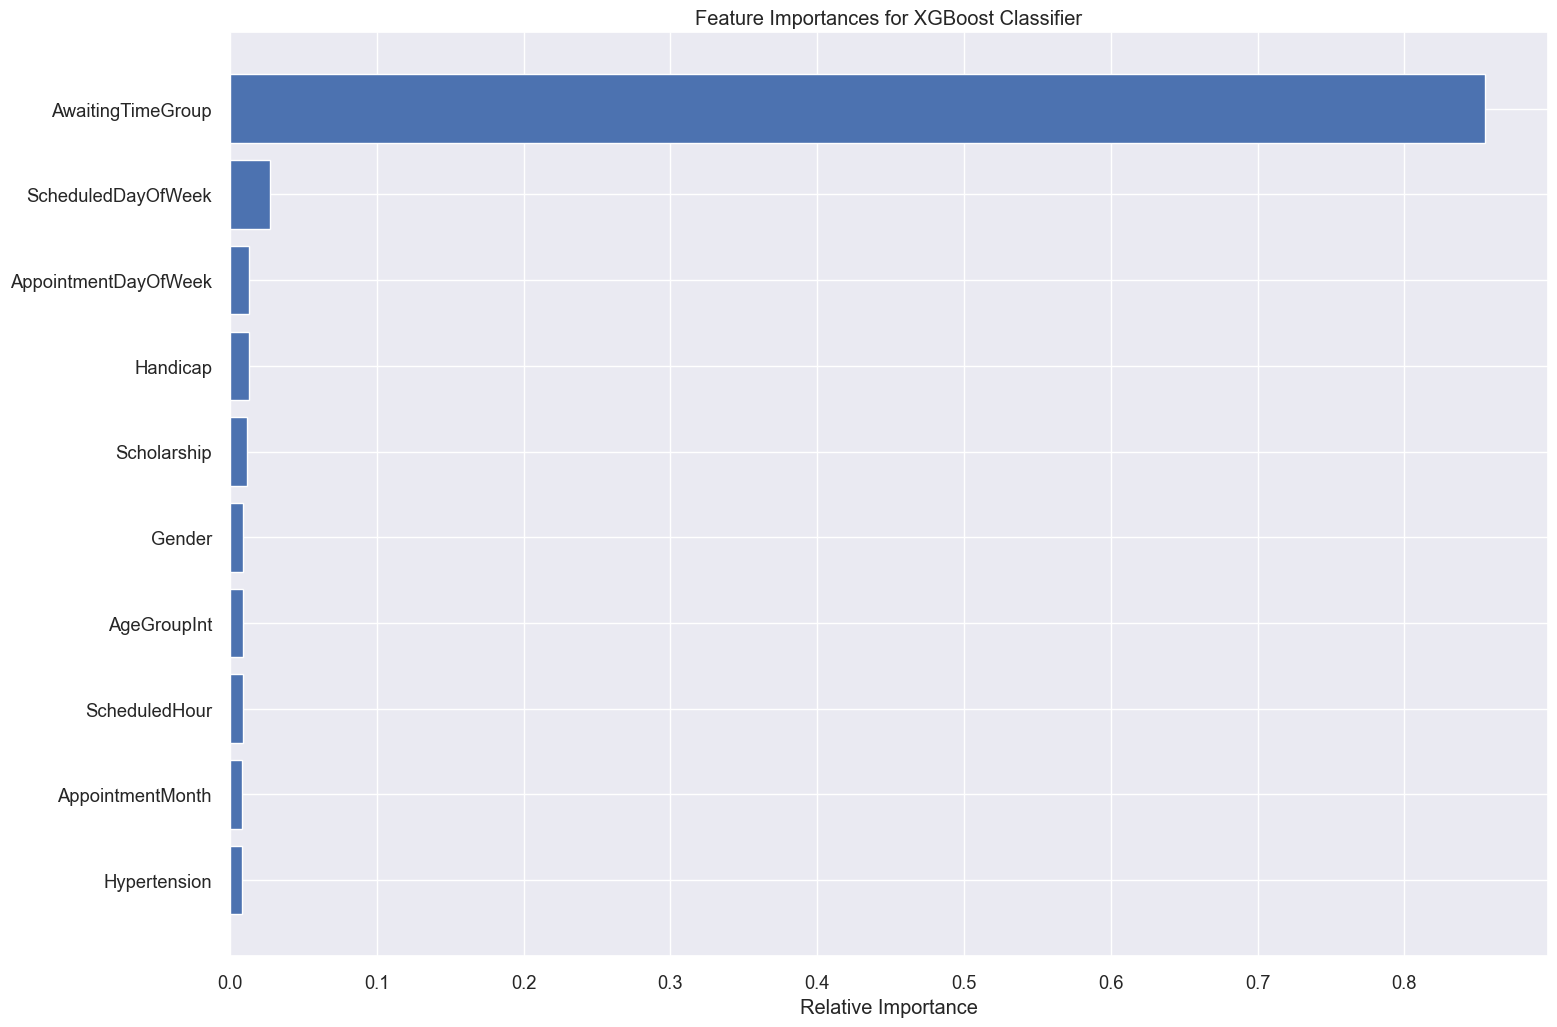

In [24]:
importances_xgboost = xgboost_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_xgboost)[-10:]
plt.title('Feature Importances for XGBoost Classifier')
plt.barh(range(len(indices)), importances_xgboost[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

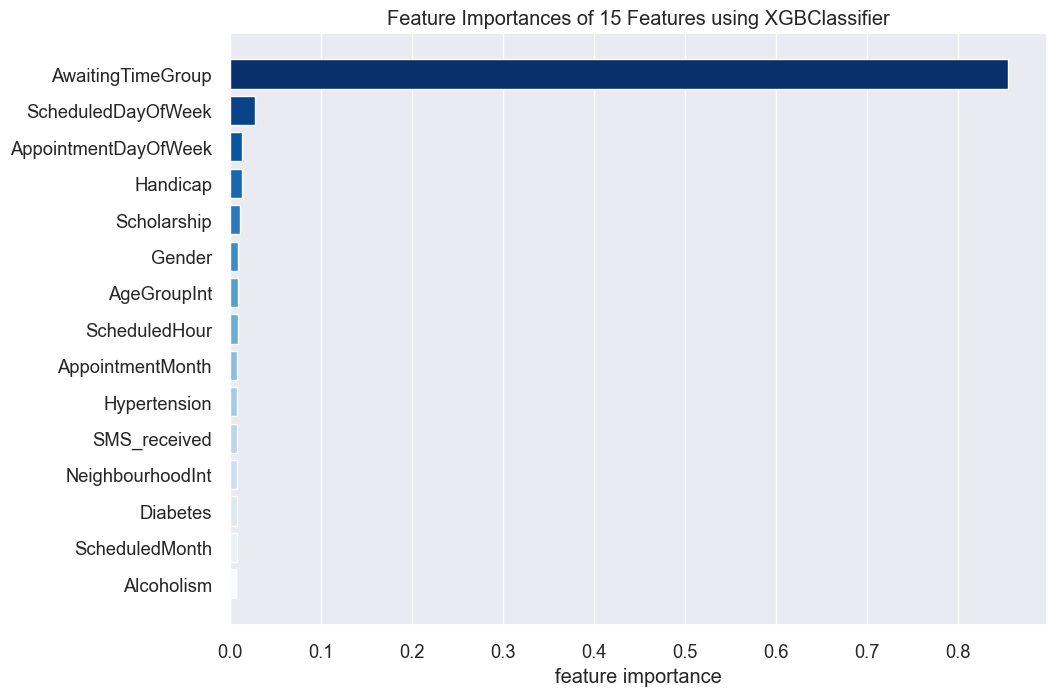

<Axes: title={'center': 'Feature Importances of 15 Features using XGBClassifier'}, xlabel='feature importance'>

In [28]:
viz = FeatureImportances(
    xgboost_cls,
    size=(1080, 720),
    relative=False,
    colormap='Blues',
)
viz.fit(X_test, y_test)
viz.show()

#### Partial Dependence Plots (PDPs)

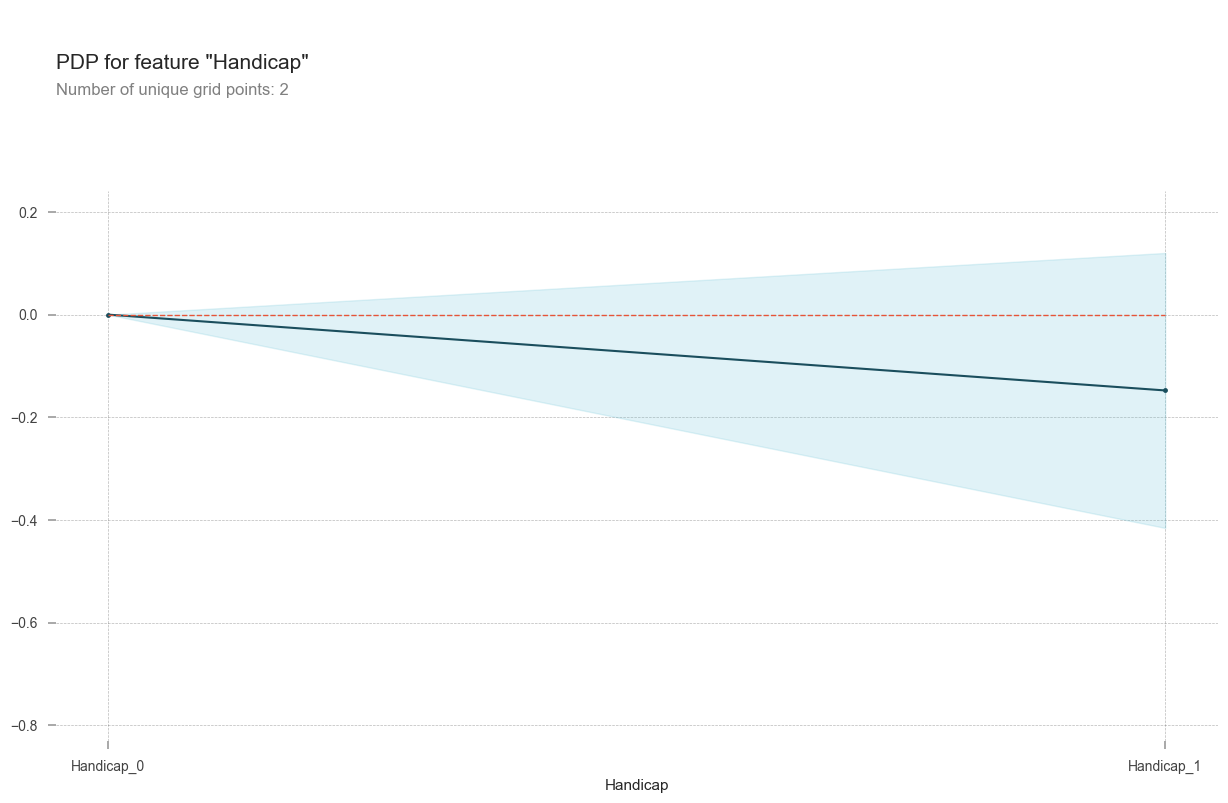

In [29]:
pdp_dist = pdp.pdp_isolate(
    model=xgboost_cls,
    dataset=X_res,
    model_features=X_res.columns,
    feature='Handicap'
)
pdp.pdp_plot(pdp_dist, 'Handicap')
plt.show()

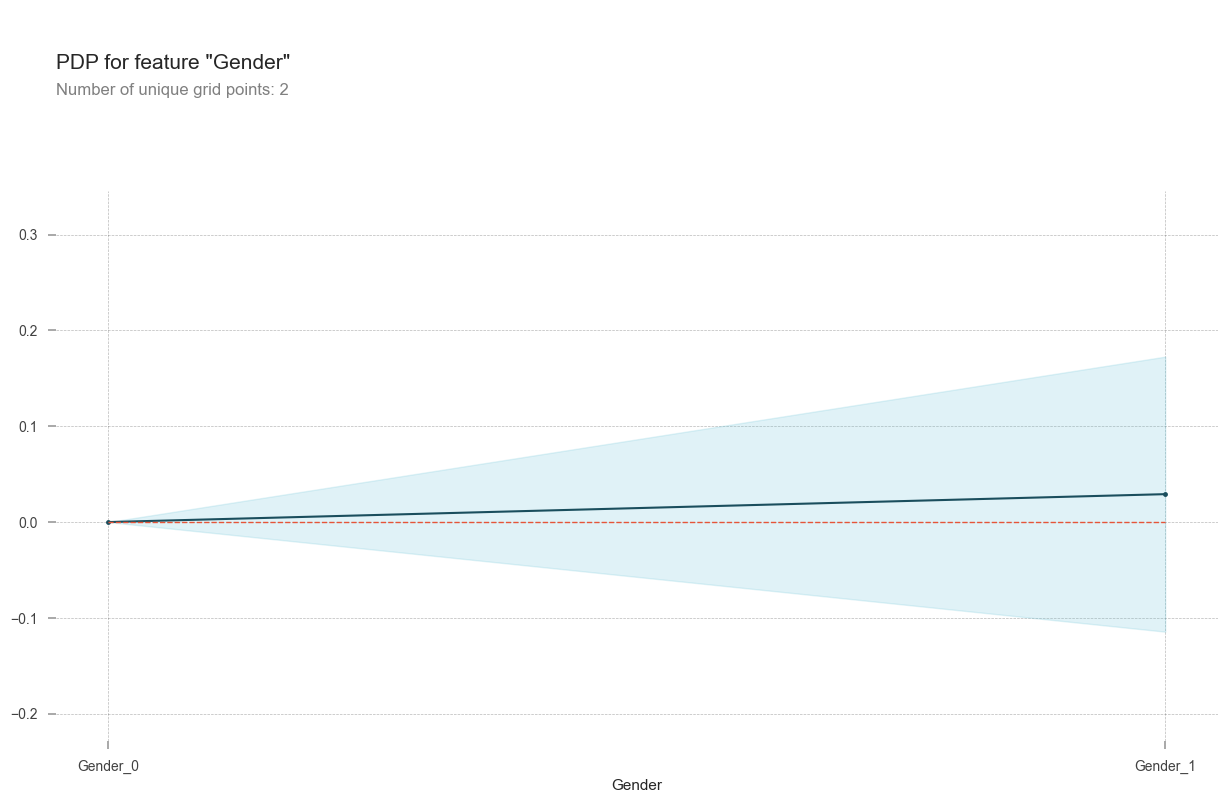

In [32]:
pdp_dist = pdp.pdp_isolate(
    model=xgboost_cls,
    dataset=X_res, 
    model_features=X_res.columns,
    feature='Gender'
)
pdp.pdp_plot(pdp_dist, 'Gender')
plt.show()

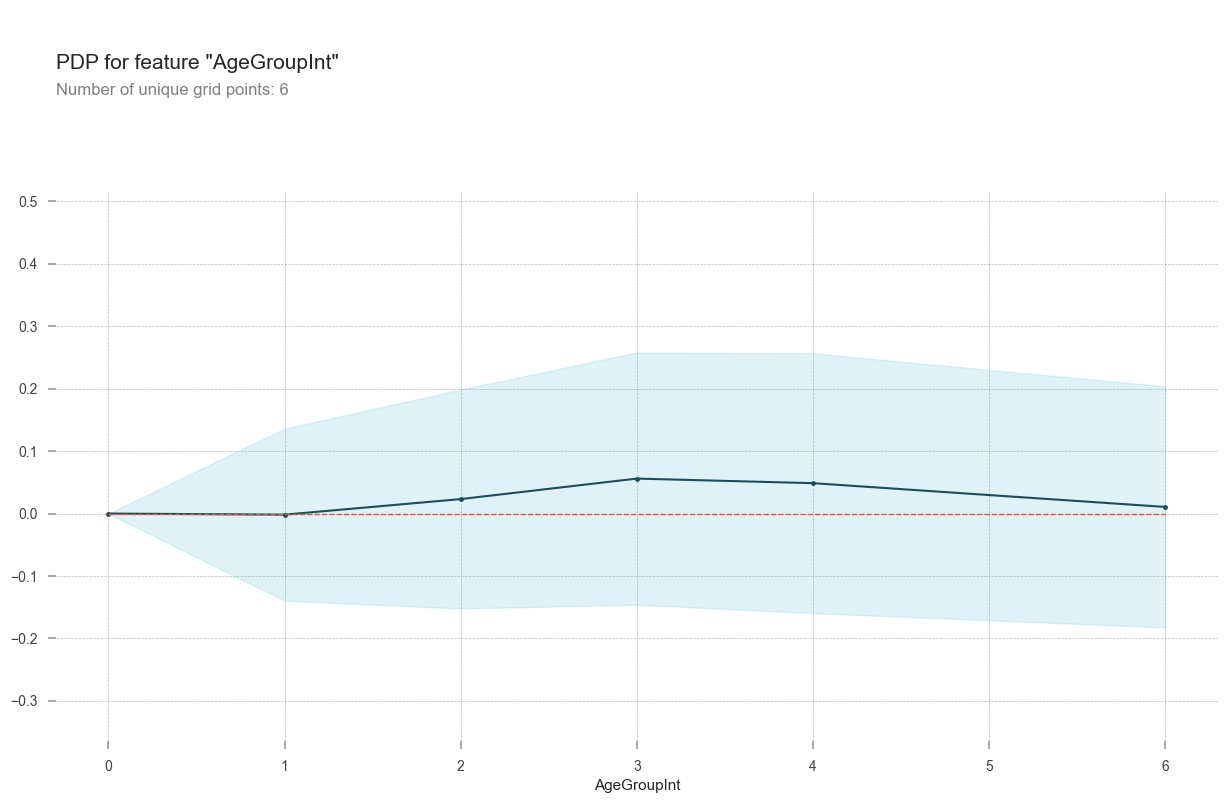

In [33]:
pdp_dist = pdp.pdp_isolate(model=xgboost_cls, dataset=X, model_features=X.columns, feature='AgeGroupInt')
pdp.pdp_plot(pdp_dist, 'AgeGroupInt')
plt.show()

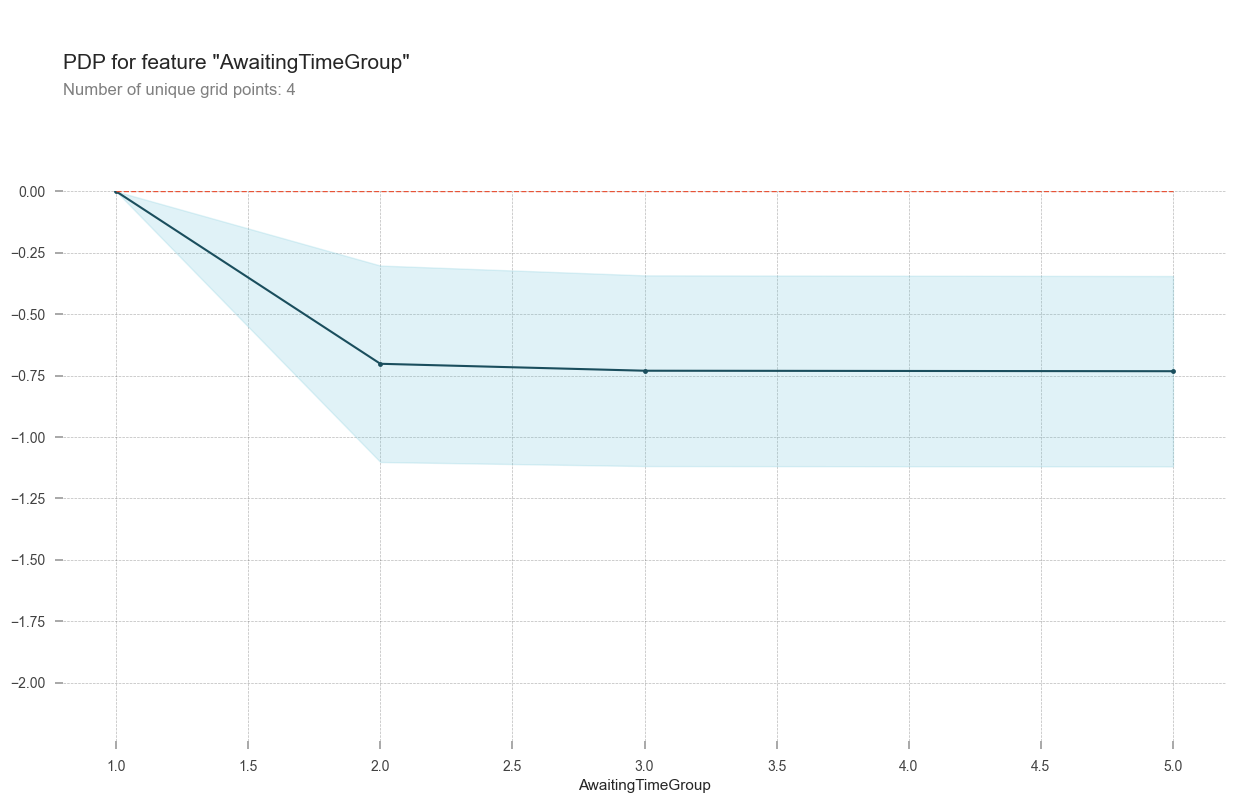

In [34]:
pdp_dist = pdp.pdp_isolate(
    model=xgboost_cls, 
    dataset=X_res, 
    model_features=X.columns, 
    feature='AwaitingTimeGroup'
)
pdp.pdp_plot(pdp_dist, 'AwaitingTimeGroup')
plt.show()

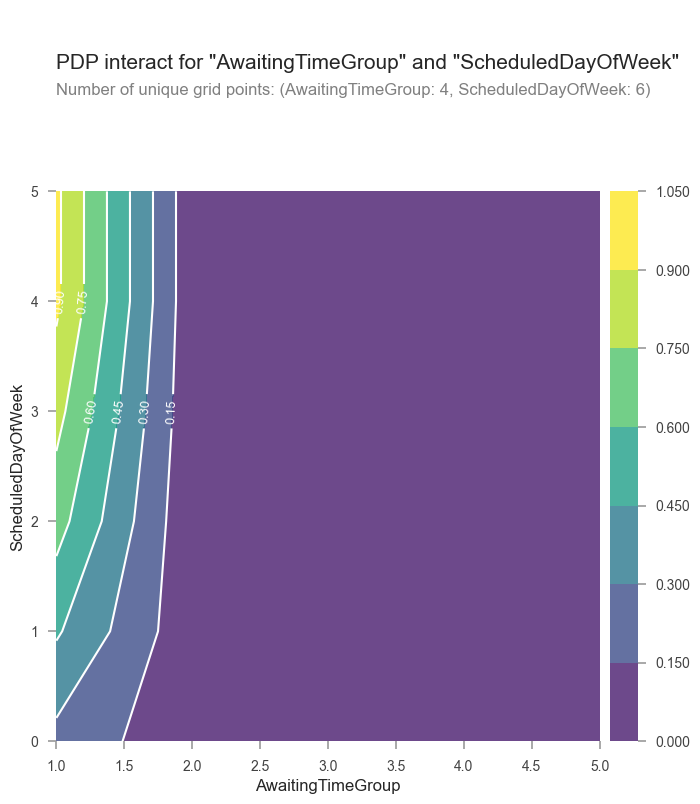

In [38]:
pdp_dist = pdp.pdp_interact(
    model=xgboost_cls,
    dataset=X_res,
    model_features=X_res.columns,
    features=['AwaitingTimeGroup', 'ScheduledDayOfWeek']
)
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'ScheduledDayOfWeek'], plot_type='contour')
plt.show()

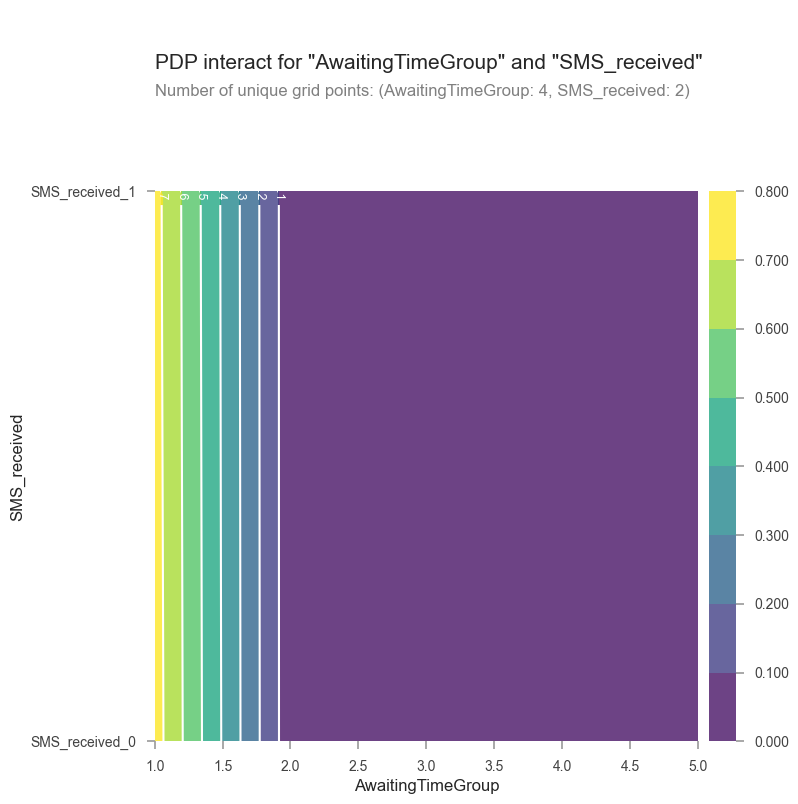

In [39]:
pdp_dist = pdp.pdp_interact(model=xgboost_cls, dataset=X_res, model_features=X_res.columns, features=['AwaitingTimeGroup', 'SMS_received'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'SMS_received'], plot_type='contour')
plt.show()

#### Individual Conditional Expectation (ICE)


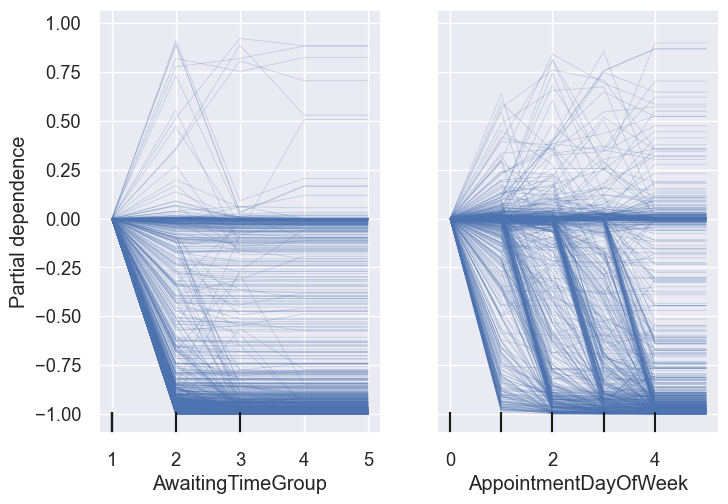

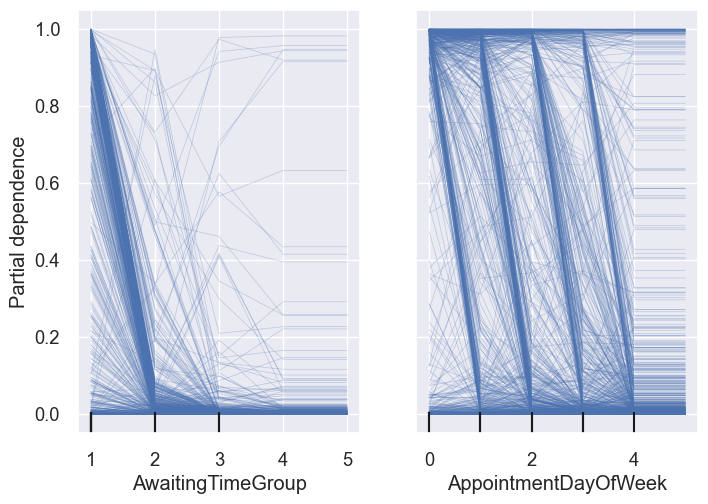

In [42]:
PartialDependenceDisplay.from_estimator(
    xgboost_cls,
    X_res,
    features=['AwaitingTimeGroup', 'AppointmentDayOfWeek'],
    kind='individual',
    centered=True,
    subsample=1000,
).plot()

#### LIME

In [43]:
X_test.shape

(13452, 15)

In [48]:
lime = LimeTabular(
    model=xgboost_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[:5],
    y_test[:5],
    name='LIME'
)
show(lime_local)

<!-- http://127.0.0.1:7001/12444454384/ -->

In [49]:
X_test[:5]

Gender  Scholarship  Hypertension  Diabetes  Alcoholism  Handicap  \
27030       0            0             0         0           0         0   
42501       1            0             0         0           0         0   
21165       1            0             1         0           0         0   
25165       1            0             0         0           0         0   
37724       1            1             1         0           0         0   

       SMS_received  ScheduledHour  ScheduledMonth  AppointmentMonth  \
27030             0              8               5                 5   
42501             0              9               6                 6   
21165             0              6               6                 6   
25165             1              6               4                 5   
37724             0              7               5                 5   

       ScheduledDayOfWeek  AppointmentDayOfWeek  AgeGroupInt  \
27030                   0                     0            0   
42501                   3                     3            2   
21165                   0                     2            5   
25165                   3                     0            3   
37724                   1                     1            3   

       NeighbourhoodInt  AwaitingTimeGroup  
27030                 7                  1  
42501                22                  1  
21165                30                  2  
25165                41                  2  
37724                 6                  1

In [50]:
y_test[:5]

27030    1
42501    1
21165    0
25165    1
37724    1
Name: Show, dtype: int64

#### SHAP

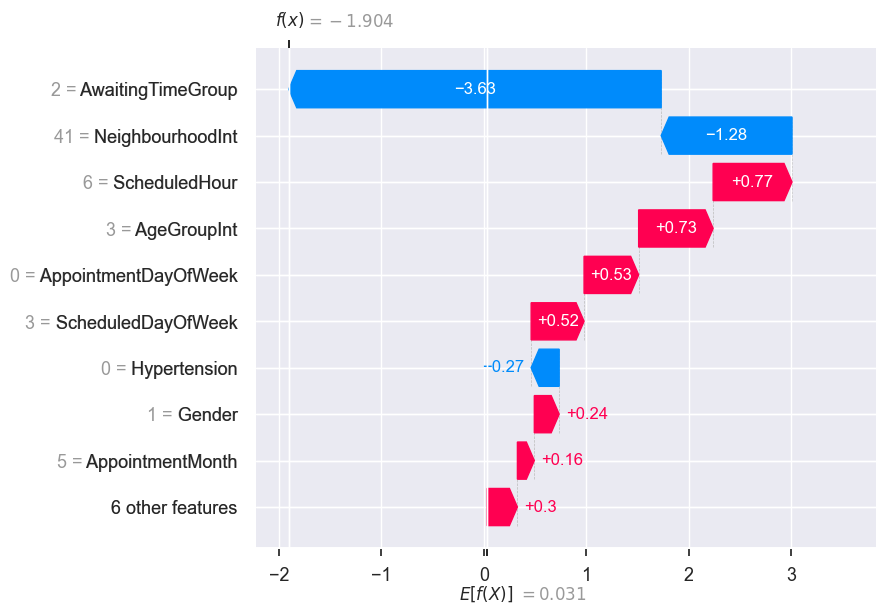

In [53]:
explainer = shap.Explainer(xgboost_cls)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[3])

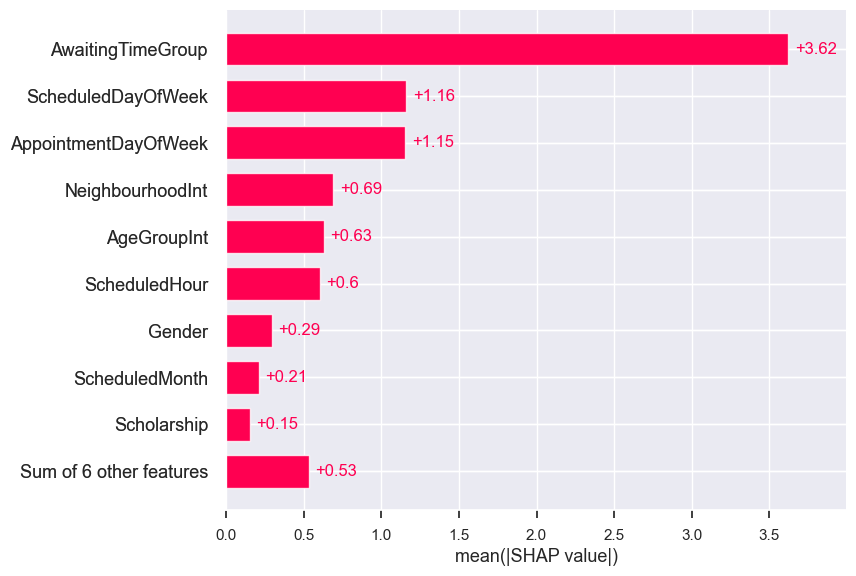

In [54]:
shap.plots.bar(shap_values)

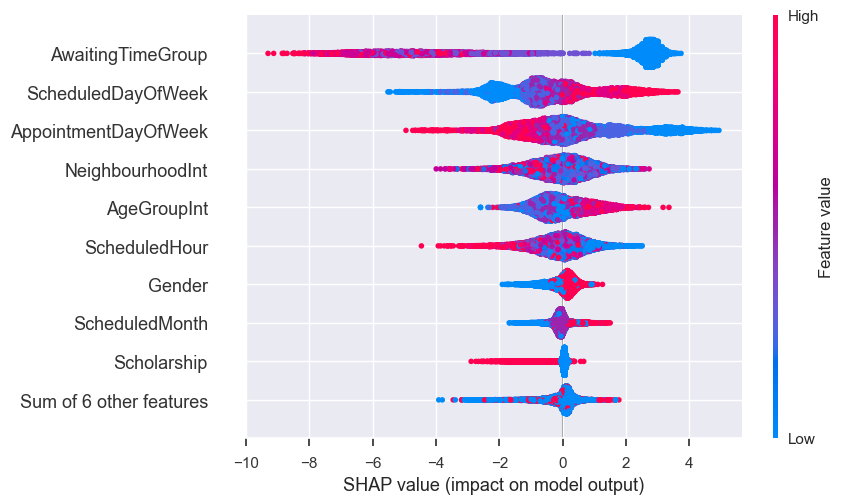

In [55]:
shap.plots.beeswarm(shap_values)

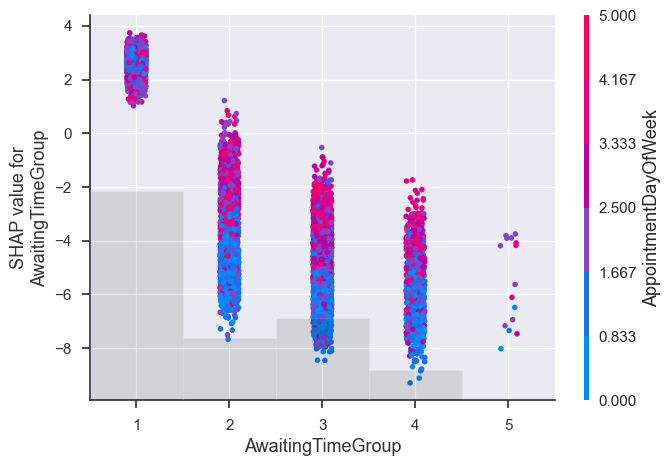

In [56]:
shap.plots.scatter(shap_values[:, "AwaitingTimeGroup"], color=shap_values)

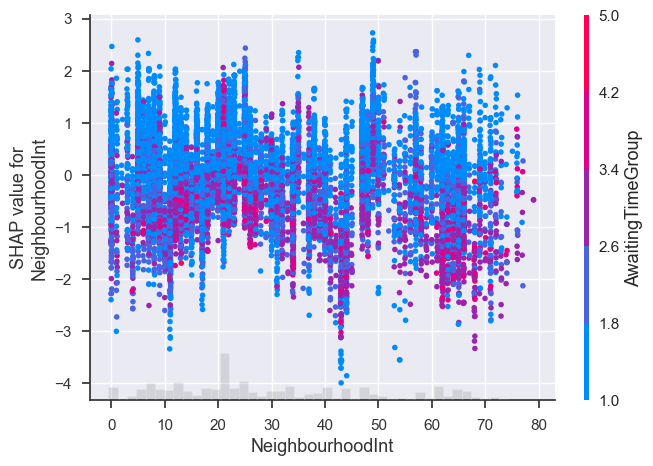

In [57]:
shap.plots.scatter(shap_values[:, "NeighbourhoodInt"], color=shap_values)

### 🌳 🌴 Random Forest

#### Hyperparameter tuning

In [60]:
config = {
    "name": "Random Forest Classifier",
    "method": "bayes",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "n_estimators": {
            "values": [50, 100, 150, 200, 500, 1000]
        },
        "min_samples_split": {
            "values": [2, 4, 6]
        },
        "min_samples_leaf": {
            "values": [1, 2, 3]
        },
    }
}

In [61]:
def train():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config

    model = RandomForestClassifier(
        n_estimators=config.n_estimators,
        criterion='gini',
        max_depth=None,
        min_samples_split=config.min_samples_split,
        min_samples_leaf=config.min_samples_leaf,
        max_features='auto',
        verbose=0,
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    wandb.log({"accuracy": accuracy, "f1": f1})
    wandb.log({"recall": recall, "precision": precision})

In [62]:
sweep_id = wandb.sweep(config, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id, function=train, count=15)

Create sweep with ID: fdl41r5k
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize-final/sweeps/fdl41r5k


wandb: Agent Starting Run: tmuu60yg with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 5n9xv1hr with config:
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: o6bhr6mr with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 69wblu8v with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: d1rsvrpg with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s9kqvojo with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: yxysfbtl with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nyponbvr with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: le7arb3h with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: hjebes3d with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: wvvc46ft with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 0dcrpdu4 with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: i36naaof with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: fvv997cl with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 500
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: r1446wiy with config:
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 2
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


In [30]:
wandb.finish()

#### Random Forest with the best hyperparameters training and evaluation

In [65]:
best_config = {
    "criterion": "gini",
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 200,
}

rf_cls = RandomForestClassifier(
    n_estimators=best_config['n_estimators'],
    criterion=best_config['criterion'],
    max_depth=None,
    min_samples_split=best_config['min_samples_split'],
    min_samples_leaf=best_config['min_samples_leaf'],
    max_features='auto',
    verbose=0,
    random_state=42,
)

rf_cls.fit(X_train, y_train)

y_pred = rf_cls.predict(X_test)

test_accuracy_rf = accuracy_score(y_test, y_pred)
test_f1_rf = f1_score(y_test, y_pred, average='macro')

train_accuracy_rf = accuracy_score(y_train, rf_cls.predict(X_train))
train_f1_rf = f1_score(y_train, rf_cls.predict(X_train), average='macro')

print('Test Accuracy: %.2f%%' % (test_accuracy_rf * 100.0))
print('Test F1 score: %.2f%%' % (test_f1_rf * 100.0))

print('Train Accuracy: %.2f%%' % (train_accuracy_rf * 100.0))
print('Train F1 score: %.2f%%' % (train_f1_rf * 100.0))

Test Accuracy: 95.28%
Test F1 score: 95.28%
Train Accuracy: 99.68%
Train F1 score: 99.67%


#### Feature importance

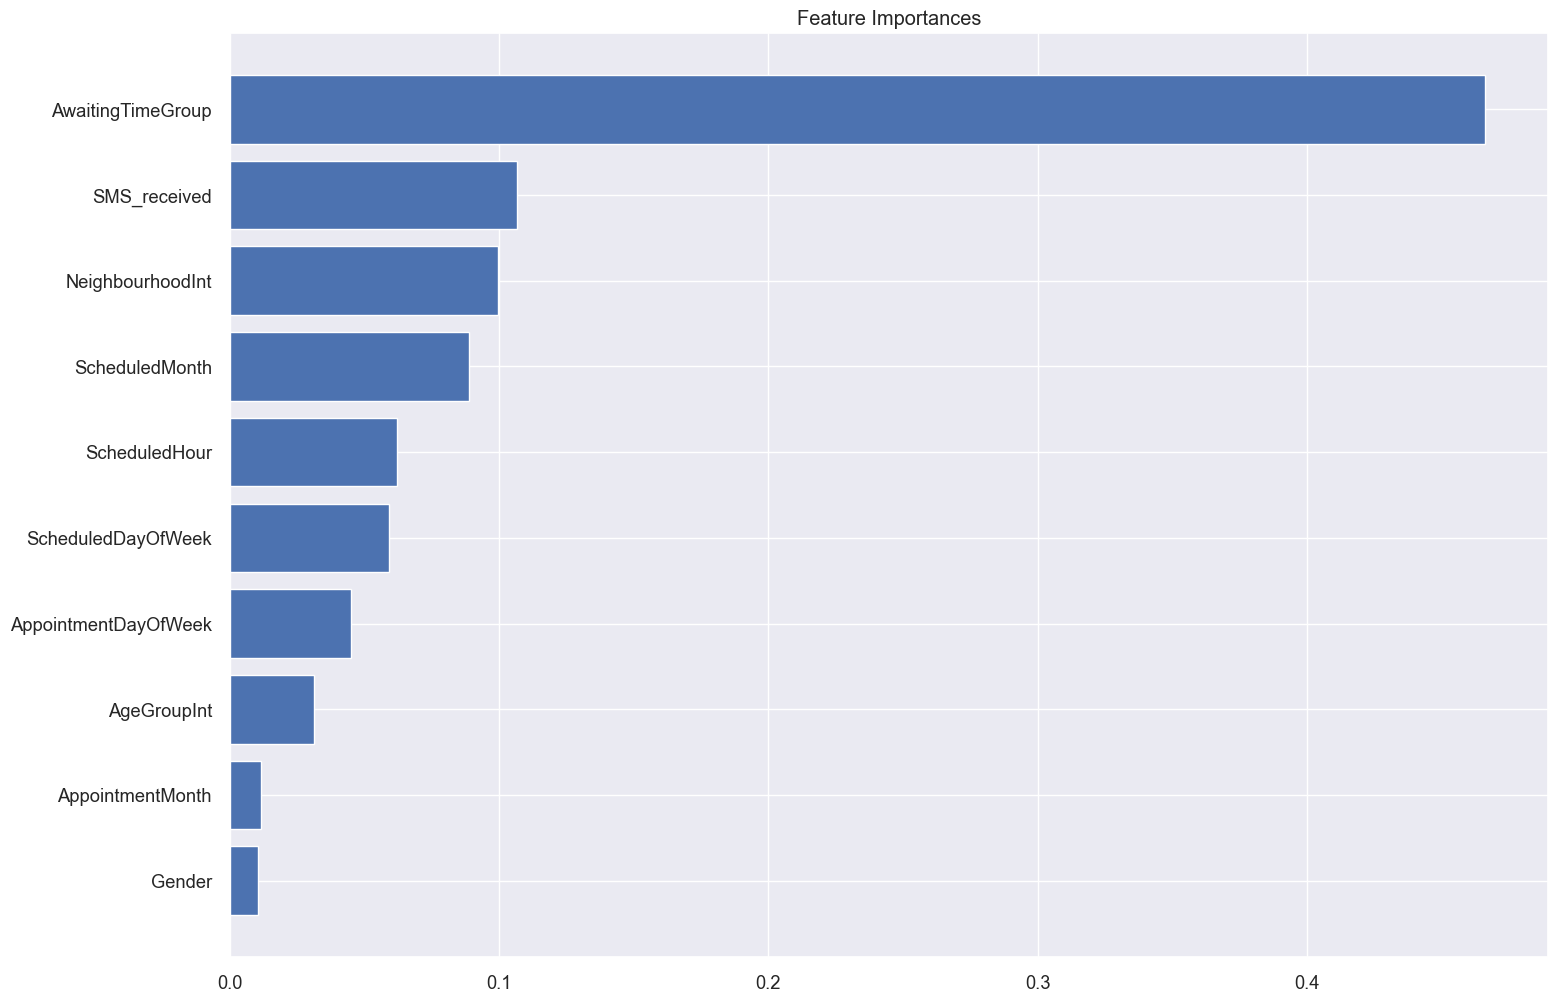

In [66]:
importances_rf = rf_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
# limit to ten features
indices = np.argsort(importances_rf)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_rf[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

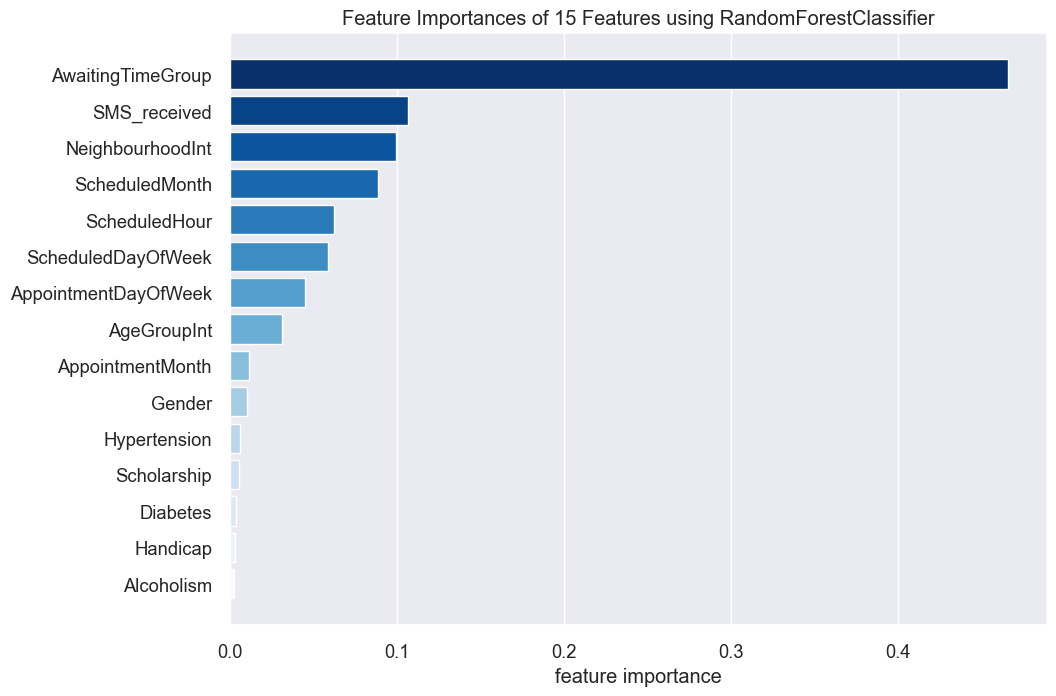

<Axes: title={'center': 'Feature Importances of 15 Features using RandomForestClassifier'}, xlabel='feature importance'>

In [67]:
viz = FeatureImportances(
    rf_cls,
    size=(1080, 720),
    relative=False,
    colormap='Blues',
)
viz.fit(X_test, y_test)
viz.show()

#### Individual Conditional Expectation (ICE)


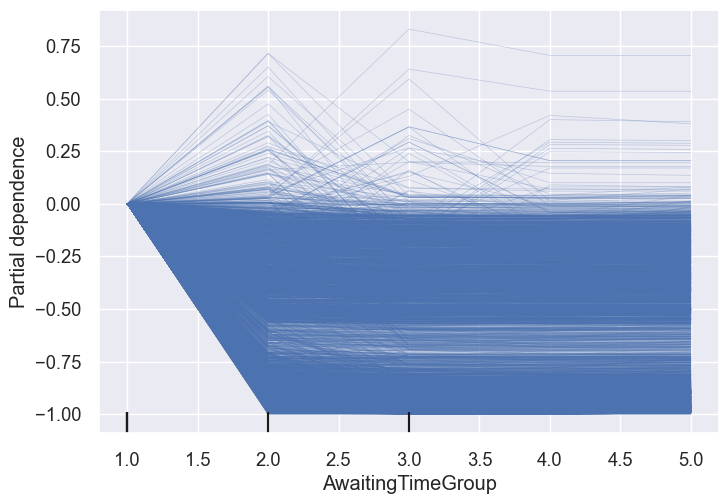

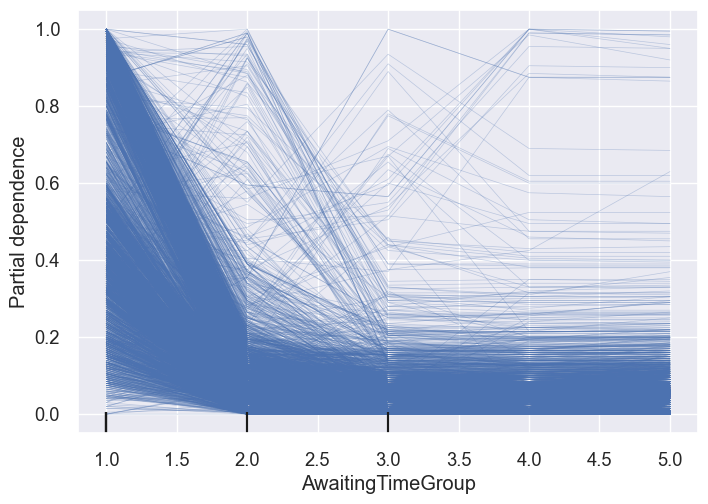

In [68]:
PartialDependenceDisplay.from_estimator(
    rf_cls,
    X_res,
    features=['AwaitingTimeGroup'],
    kind='individual',
    centered=True,
    subsample=5000,
).plot()

#### Partial Dependence Plots (PDPs)

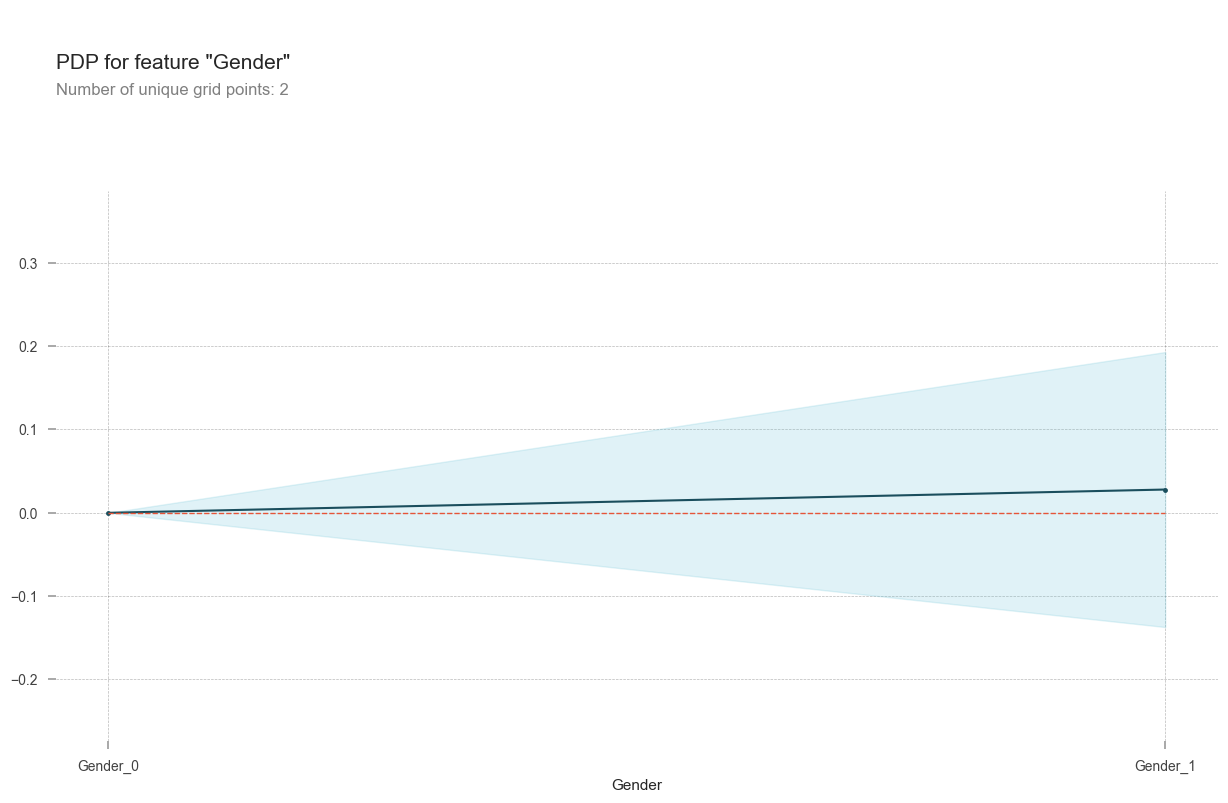

In [69]:
pdp_dist = pdp.pdp_isolate(model=rf_cls, dataset=X, model_features=X.columns, feature='Gender')
pdp.pdp_plot(pdp_dist, 'Gender')
plt.show()

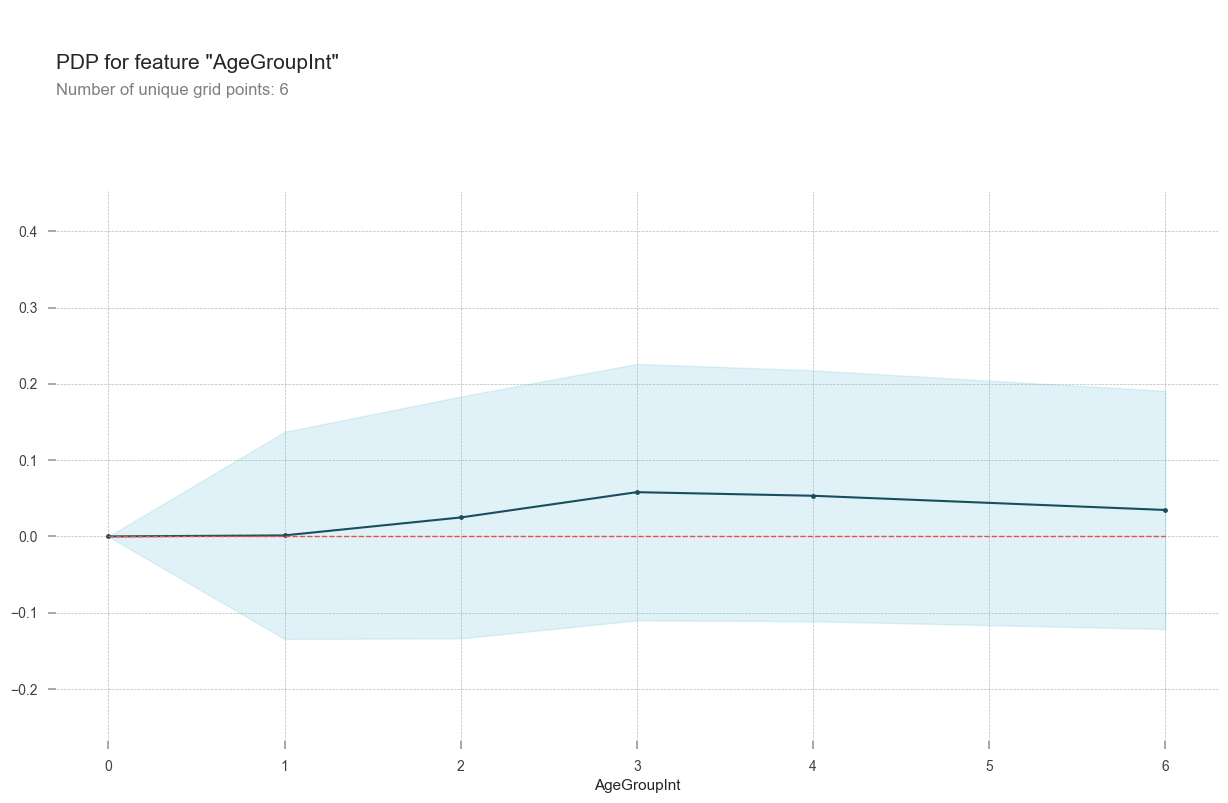

In [96]:
pdp_dist = pdp.pdp_isolate(model=rf_cls, dataset=X, model_features=X.columns, feature='AgeGroupInt')
pdp.pdp_plot(pdp_dist, 'AgeGroupInt')
plt.show()

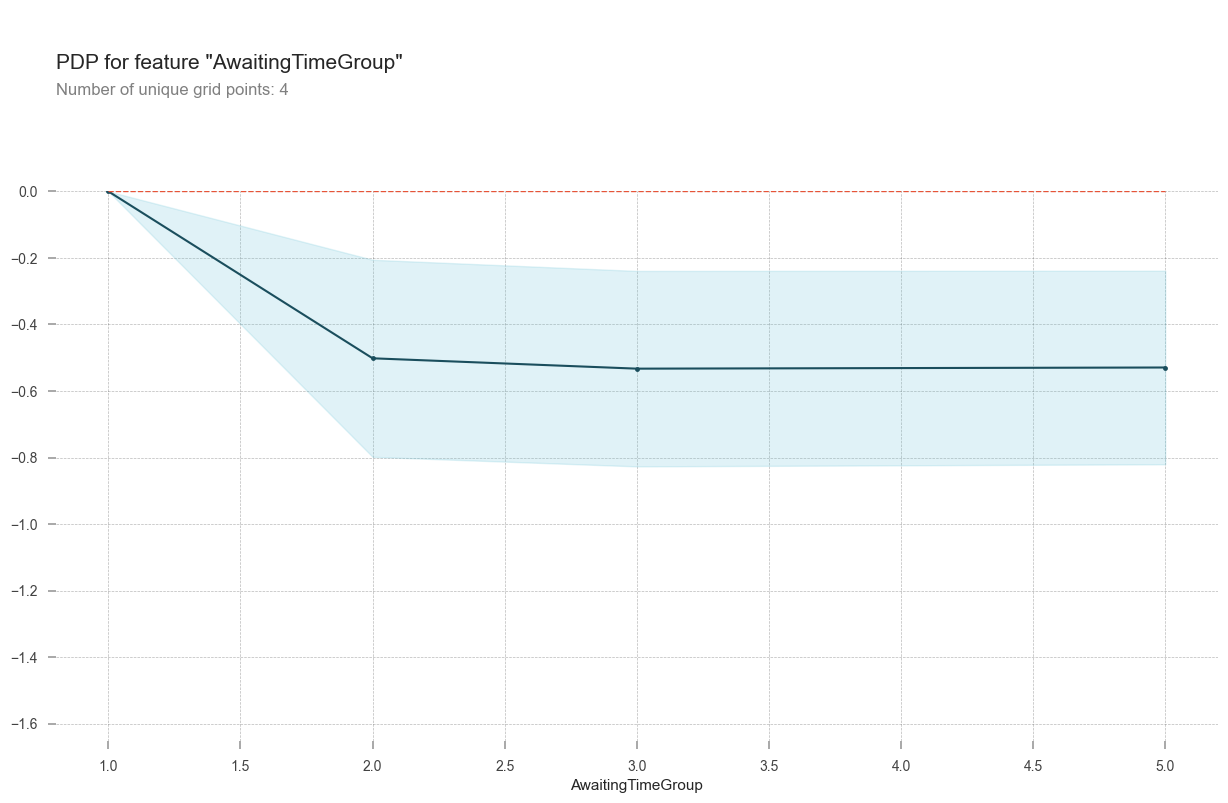

In [70]:
pdp_dist = pdp.pdp_isolate(
    model=rf_cls, 
    dataset=X, 
    model_features=X.columns, 
    feature='AwaitingTimeGroup'
)
pdp.pdp_plot(pdp_dist, 'AwaitingTimeGroup')
plt.show()

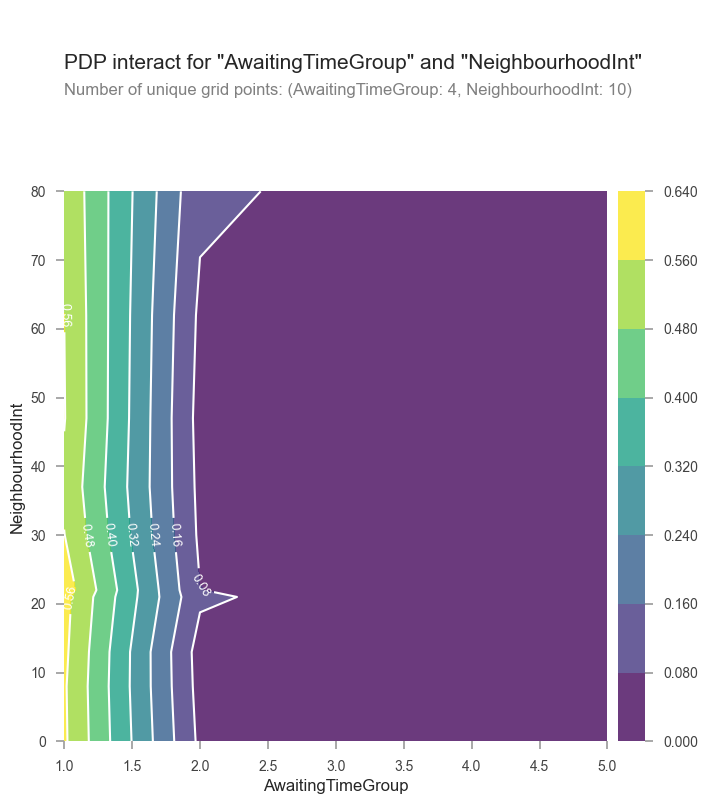

In [71]:
pdp_dist = pdp.pdp_interact(model=rf_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'NeighbourhoodInt'], plot_type='contour')
plt.show()

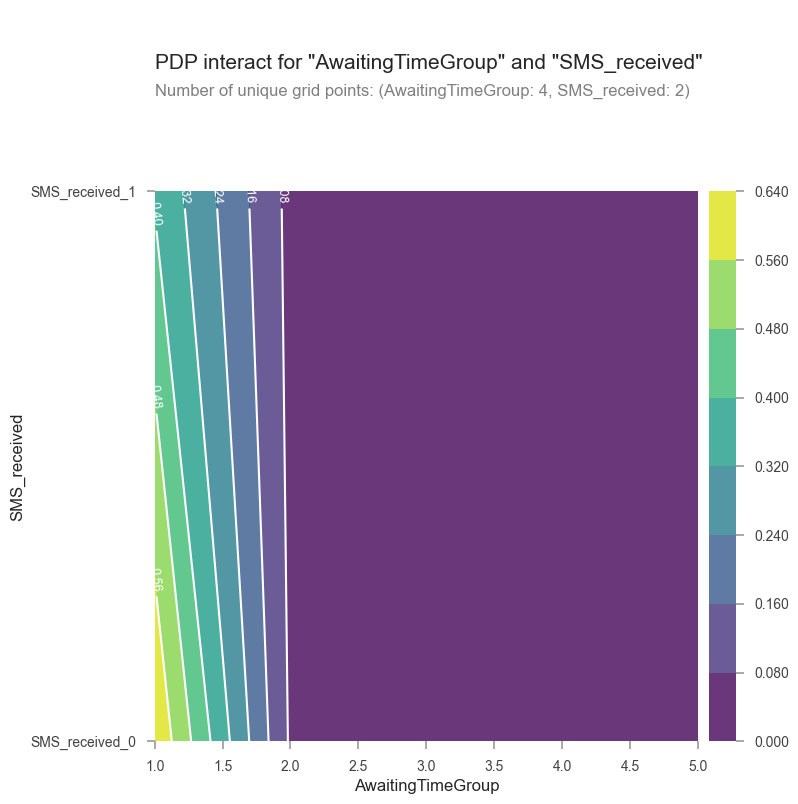

In [72]:
pdp_dist = pdp.pdp_interact(model=rf_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'SMS_received'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'SMS_received'], plot_type='contour')
plt.show()

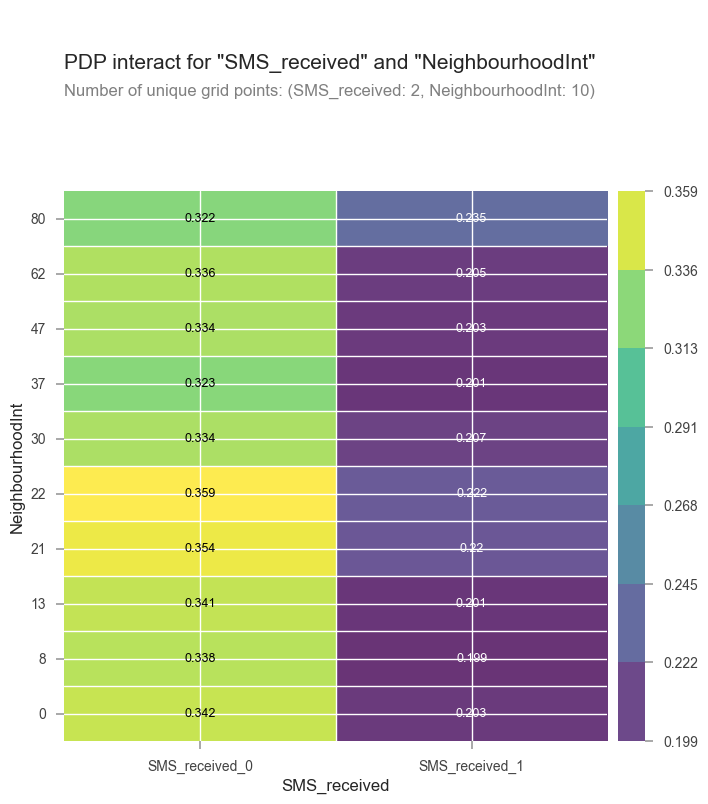

In [73]:
pdp_dist = pdp.pdp_interact(model=rf_cls, dataset=X, model_features=X.columns, features=['SMS_received', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['SMS_received', 'NeighbourhoodInt'], plot_type='grid')
plt.show()

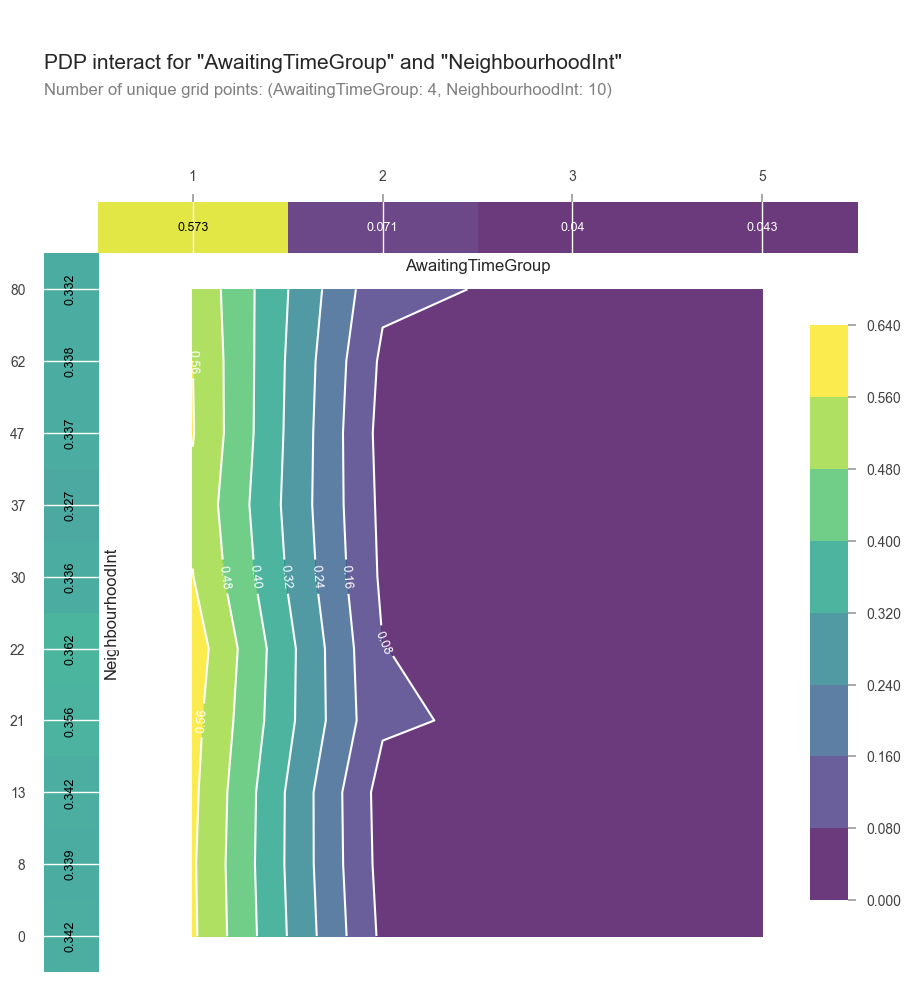

In [74]:
pdp_dist = pdp.pdp_interact(model=rf_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'NeighbourhoodInt'], plot_type='contour', plot_pdp=True)
plt.show()

#### LIME 

In [102]:
X_test.shape

(13452, 15)

In [75]:
lime = LimeTabular(
    model=rf_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[:5],
    y_test[:5],
    name='LIME'
)

show(lime_local)

<!-- http://127.0.0.1:7001/12605233424/ -->

#### SHAP

In [104]:
explainer = shap.Explainer(rf_cls)
shap_values = explainer(X_test)

shap.plots.waterfall(shap_values[12995])

### 💥 Gradient Boosting

#### Hyperparameter tuning

In [76]:
gb_config = {
    "name": "Gradient Boosting",
    "method": "bayes",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "n_estimators": {
            "values": [10, 50, 100, 150, 200]
        },
        "learning_rate": {
            "values": [0.001, 0.01, 0.1, 1.0]
        },
        "loss": {
            "values": ["log_loss", "deviance", "exponential"]
        },
        "criterion": {
            "values": ["friedman_mse", "squared_error"]
        },
        "min_samples_leaf": {
            "values": [1, 2, 3]
        },
        "min_samples_split": {
            "values": [2, 4, 6]
        },
    }
}

def train_gb():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config

    model = GradientBoostingClassifier(
        n_estimators=config.n_estimators,
        learning_rate=config.learning_rate,
        max_depth=None,
        loss=config.loss,
        criterion=config.criterion,
        min_samples_leaf=config.min_samples_leaf,
        min_samples_split=config.min_samples_split,
        verbose=0,
        max_features='auto',
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    wandb.log({"accuracy": accuracy, "f1": f1})
    wandb.log({"recall": recall, "precision": precision})

In [77]:
sweep_id_gb = wandb.sweep(gb_config, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id_gb, function=train_gb, count=25)

Create sweep with ID: iwtswhg0
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize-final/sweeps/iwtswhg0


wandb: Agent Starting Run: mqscgqny with config:
wandb: 	criterion: friedman_mse
wandb: 	learning_rate: 0.1
wandb: 	loss: deviance
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 6
wandb: 	n_estimators: 200
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 965v06m3 with config:
wandb: 	criterion: friedman_mse
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 2
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: 7g4m9mds with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 0.1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 100
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: srcnfrig with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: log_loss
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xb6wrv7x with config:
wandb: 	criterion: squared_error
wandb: 	learning_rate: 1
wandb: 	loss: deviance
wandb: 	min_samples_leaf: 3
wandb: 	min_samples_split: 4
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


In [15]:
wandb.finish()

#### Gradient Boosting with the best hyperparameters training and evaluation

In [19]:
best_config_gb = {
    "criterion": "squared_error",
    "learning_rate": 1,
    "loss": "log_loss",
    "min_samples_leaf": 2,
    "min_samples_split": 4,
    "n_estimators": 150,
}

gb_cls = GradientBoostingClassifier(
    n_estimators=best_config_gb['n_estimators'],
    learning_rate=best_config_gb['learning_rate'],
    max_depth=None,
    loss=best_config_gb['loss'],
    criterion=best_config_gb['criterion'],
    min_samples_leaf=best_config_gb['min_samples_leaf'],
    min_samples_split=best_config_gb['min_samples_split'],
    verbose=0,
    max_features='auto',
    random_state=42,
)

gb_cls.fit(X_train, y_train)

y_pred = gb_cls.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred)
f1_gb = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy_gb * 100.0))
print('F1 score: %.2f%%' % (f1_gb * 100.0))

Accuracy: 93.96%
F1 score: 93.96%


#### Feature importance

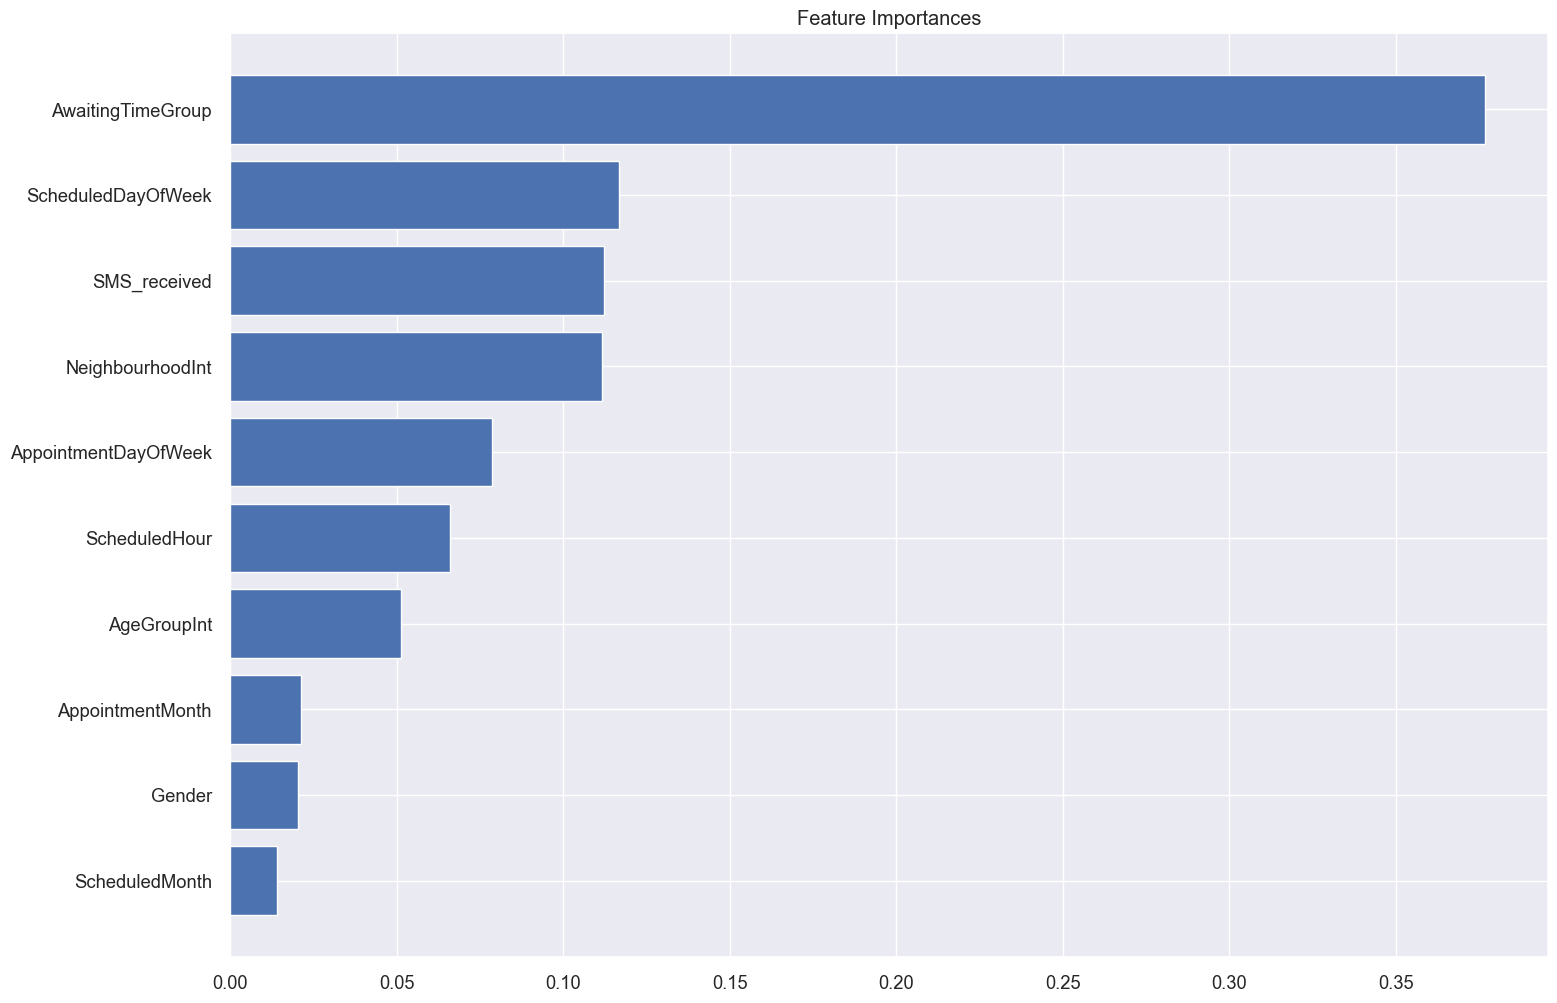

In [20]:
importances_gb = gb_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_gb)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_gb[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

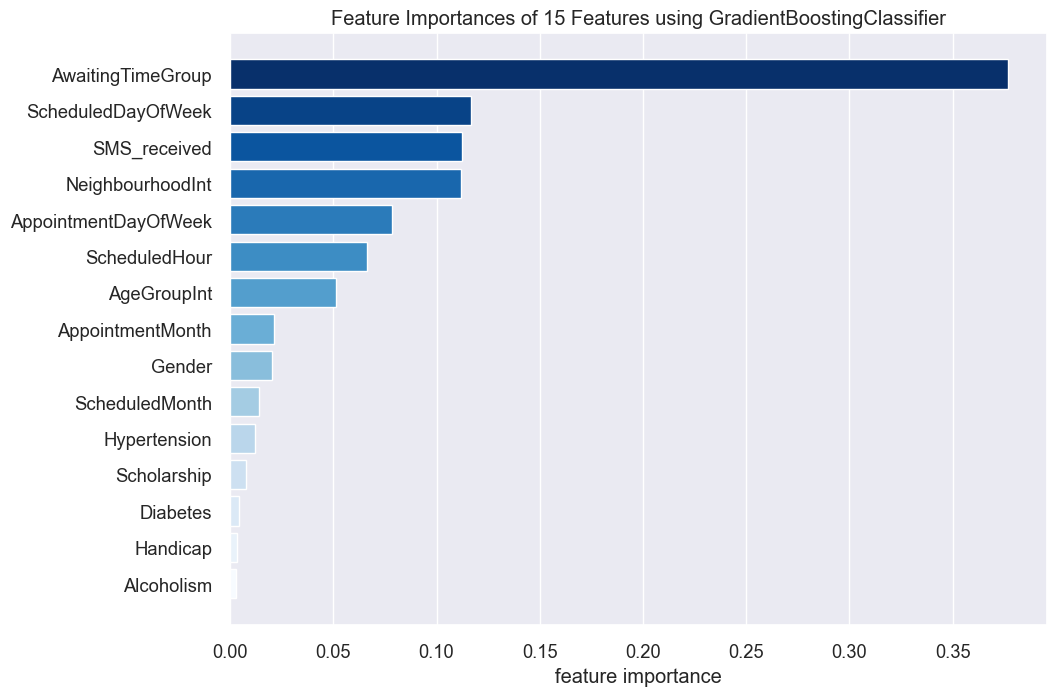

<Axes: title={'center': 'Feature Importances of 15 Features using GradientBoostingClassifier'}, xlabel='feature importance'>

In [21]:
viz = FeatureImportances(
    gb_cls,
    size=(1080, 720),
    max_num_features=10,
    relative=False,
    colormap='Blues',
)
viz.fit(X_train, y_train)
viz.show()

#### Partial Dependence Plots (PDPs)

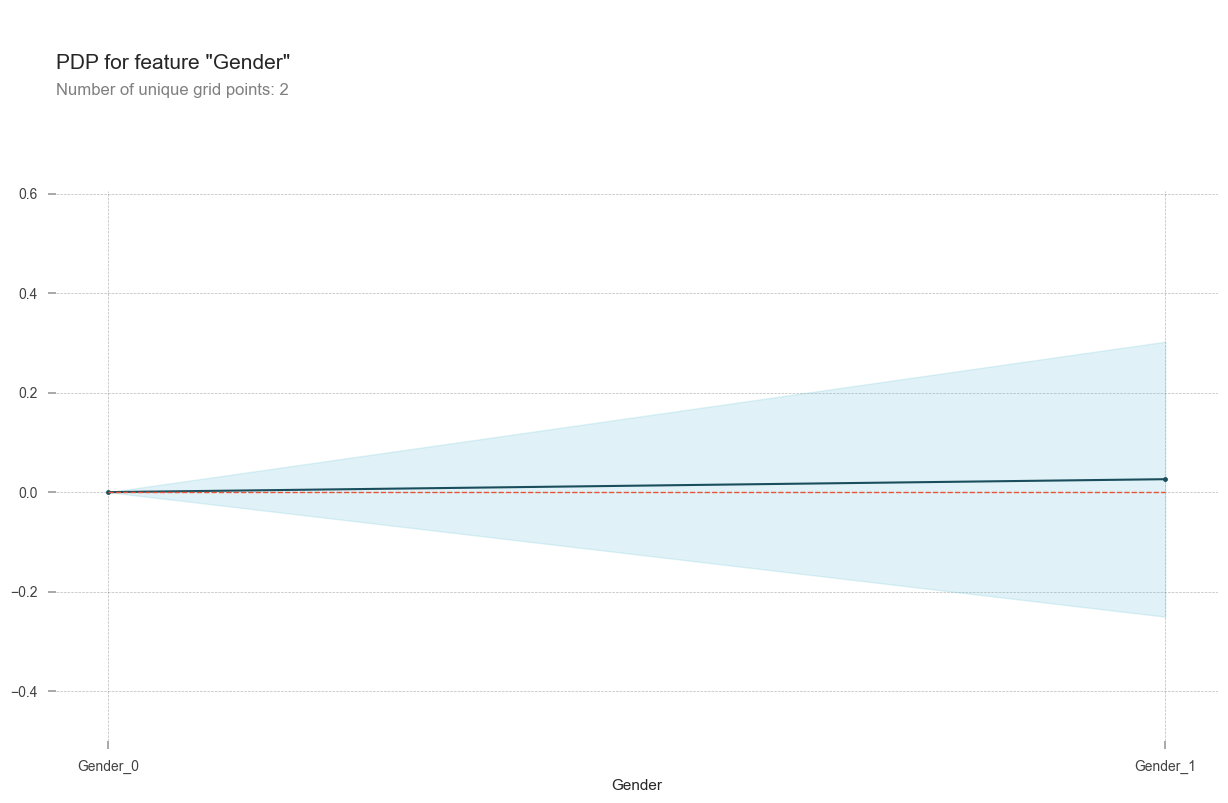

In [22]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='Gender')
pdp.pdp_plot(pdp_dist, 'Gender')
plt.show()

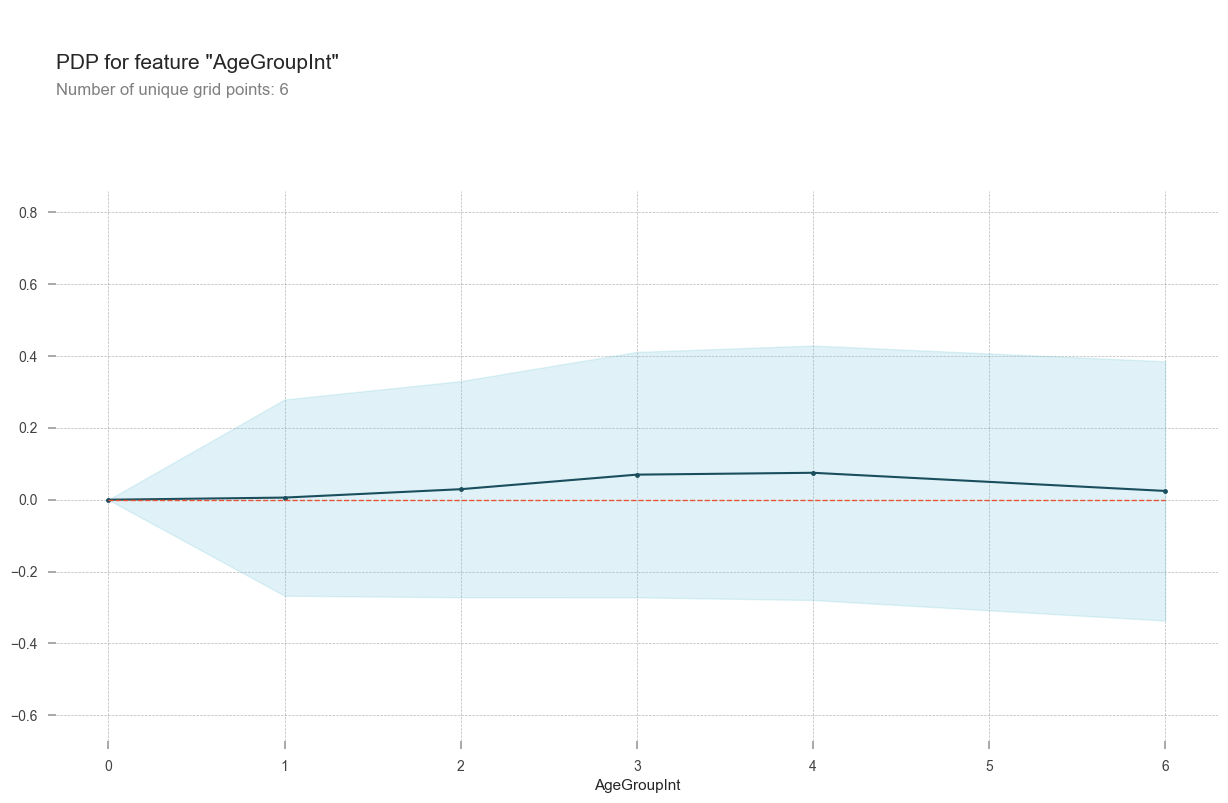

In [23]:
pdp_dist = pdp.pdp_isolate(model=gb_cls, dataset=X, model_features=X.columns, feature='AgeGroupInt')
pdp.pdp_plot(pdp_dist, 'AgeGroupInt')
plt.show()

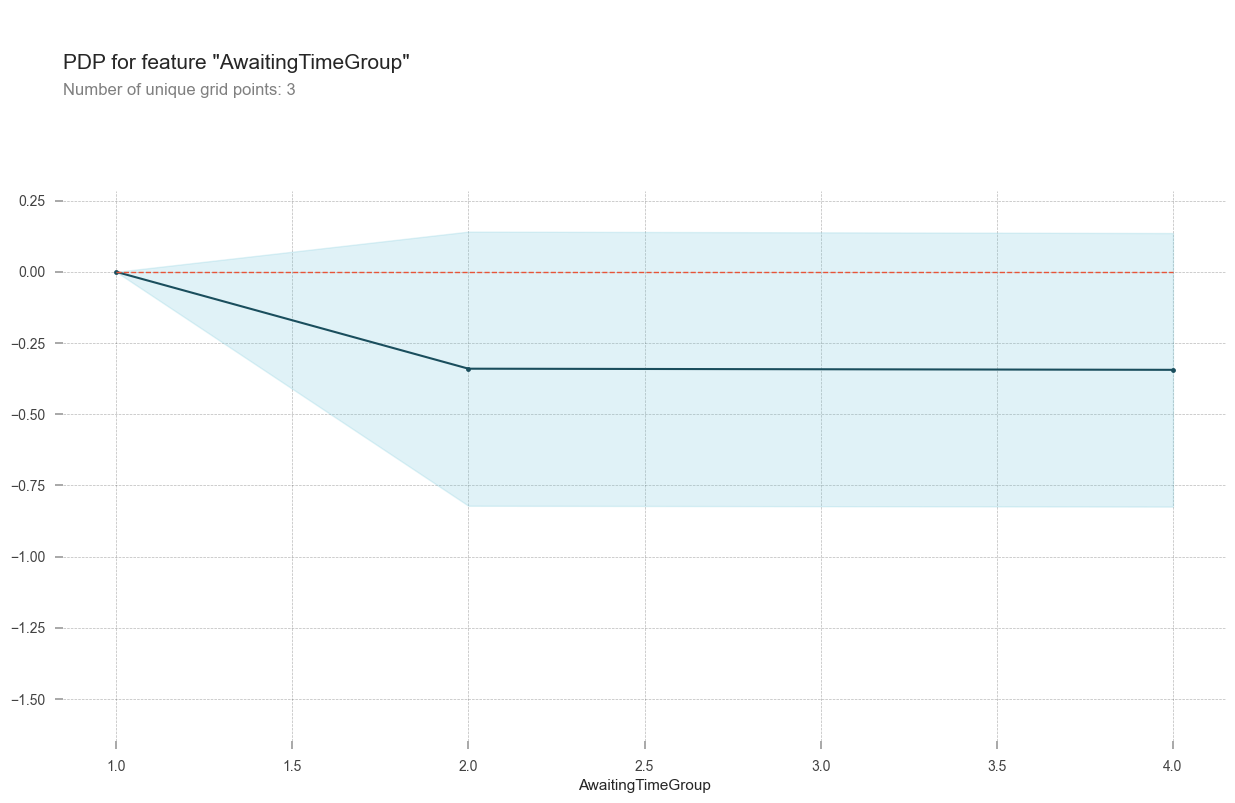

In [24]:
pdp_dist = pdp.pdp_isolate(
    model=gb_cls, 
    dataset=X, 
    model_features=X.columns, 
    feature='AwaitingTimeGroup'
)
pdp.pdp_plot(pdp_dist, 'AwaitingTimeGroup')
plt.show()

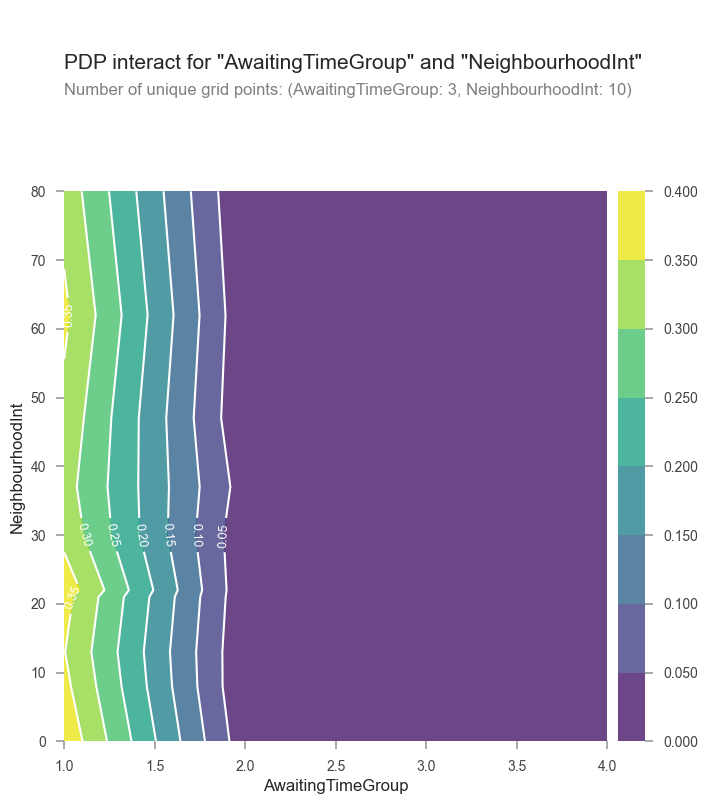

In [25]:
pdp_dist = pdp.pdp_interact(model=gb_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'NeighbourhoodInt'], plot_type='contour')
plt.show()

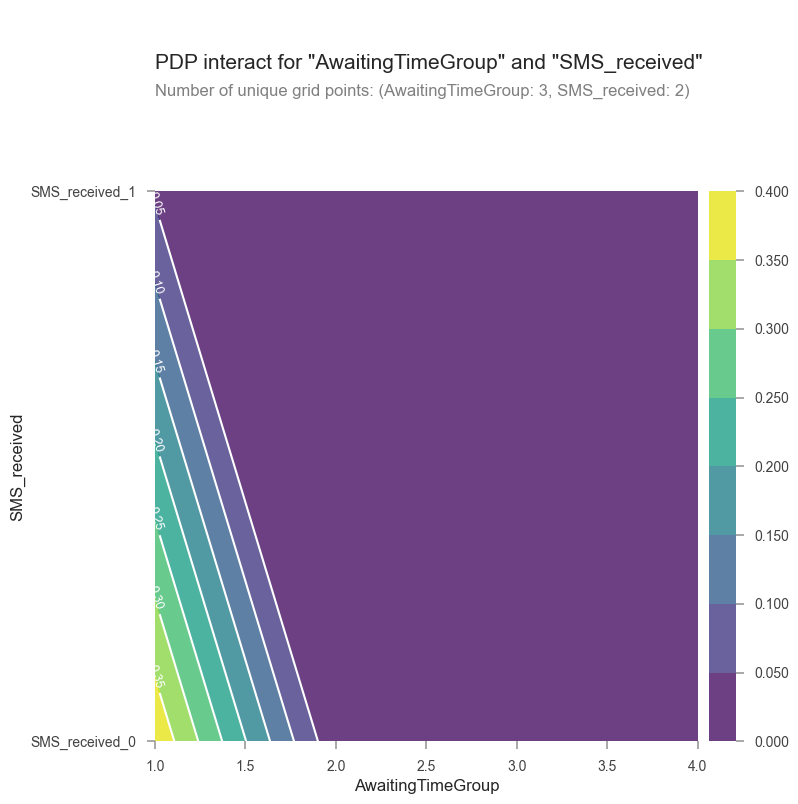

In [26]:
pdp_dist = pdp.pdp_interact(model=gb_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'SMS_received'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'SMS_received'], plot_type='contour')
plt.show()

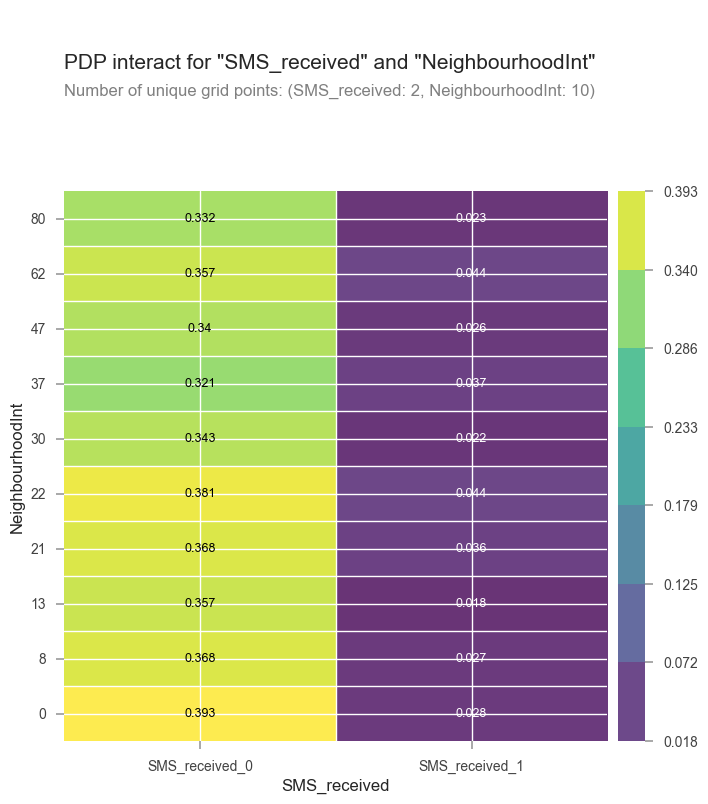

In [28]:
pdp_dist = pdp.pdp_interact(model=gb_cls, dataset=X, model_features=X.columns, features=['SMS_received', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['SMS_received', 'NeighbourhoodInt'], plot_type='grid')
plt.show()

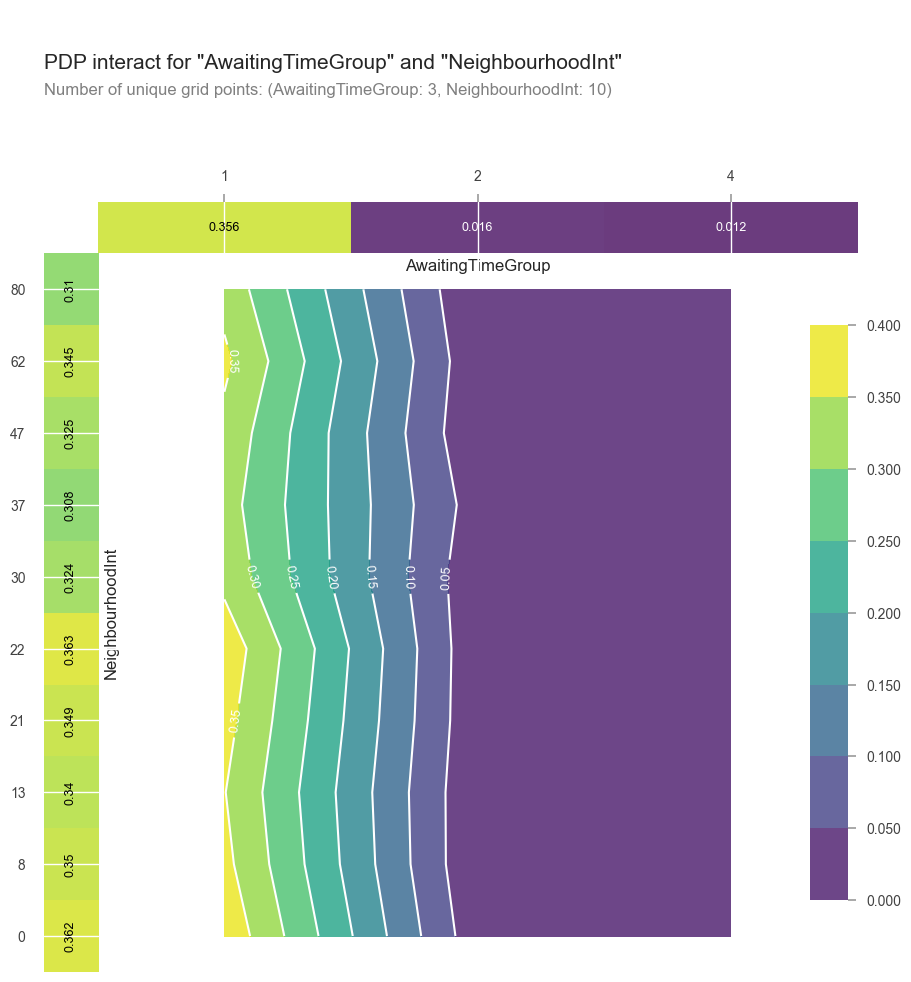

In [29]:
# add information plot
pdp_dist = pdp.pdp_interact(model=gb_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'NeighbourhoodInt'], plot_type='contour', plot_pdp=True)
plt.show()

#### Individual Conditional Expectation (ICE)


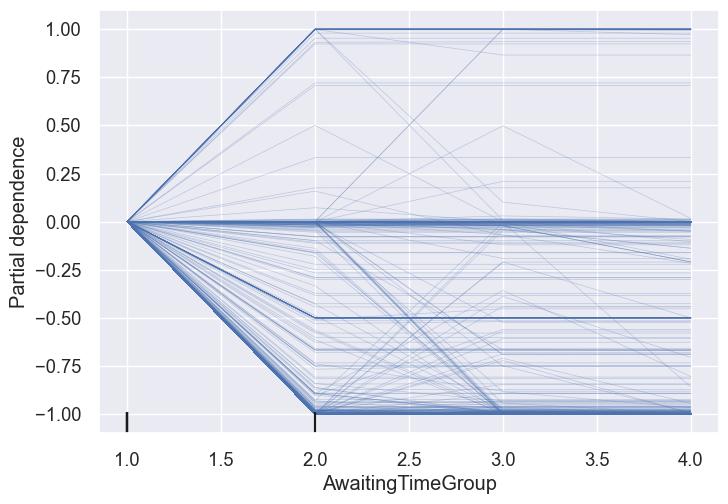

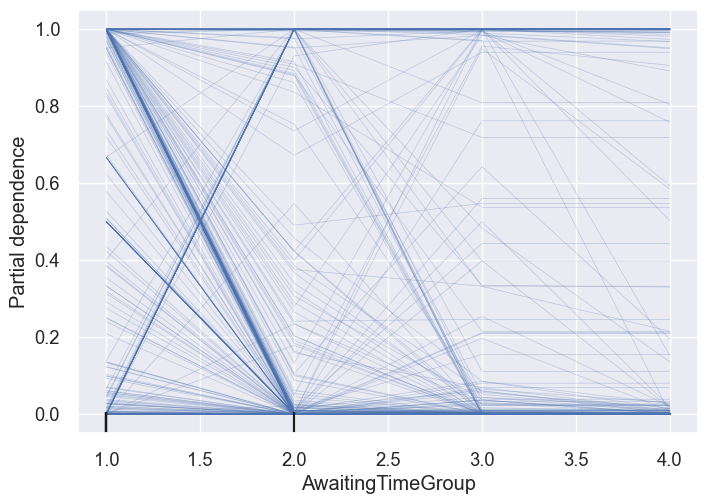

In [39]:
from sklearn.inspection import PartialDependenceDisplay


PartialDependenceDisplay.from_estimator(
    gb_cls,
    X_res,
    features=['AwaitingTimeGroup'],
    kind='individual',
    centered=True,
    subsample=5000,
).plot()


#### LIME

In [38]:
lime = LimeTabular(
    model=gb_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[1400:1402],
    y_test[1400:1402],
    name='LIME'
)

show(lime_local) 

<!-- http://127.0.0.1:7001/12076159664/ -->

#### SHAP

In [39]:
explainer = shap.Explainer(gb_cls)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)

### ☄️ AdaBoost

#### Hyperparameter tuning

In [40]:
adaboost_sweep_config = {
    "name": "Adaboost",
    "method": "bayes",
    "metric": {
        "name": "accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "n_estimators": {
            "values": [10, 50, 100, 150, 200]
        },
        "learning_rate": {
            "values": [0.001, 0.01, 0.1, 1.0]   
        },
        "algorithm": {
            "values": ["SAMME", "SAMME.R"]
        },
    }
}


def train_adaboost():
    wandb.init(project=WANDB_PROJECT_NAME, config=wandb.config)

    config = wandb.config

    model = AdaBoostClassifier(
        n_estimators=config.n_estimators,
        learning_rate=config.learning_rate,
        algorithm=config.algorithm,
        random_state=42,
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')

    wandb.log({"accuracy": accuracy, "f1": f1})
    wandb.log({"recall": recall, "precision": precision})


sweep_id_adaboost = wandb.sweep(adaboost_sweep_config, project=WANDB_PROJECT_NAME)
wandb.agent(sweep_id_adaboost, function=train_adaboost, count=10)

Create sweep with ID: 7afyfe5k
Sweep URL: https://wandb.ai/polejowska/mappshow-hp-optimize/sweeps/7afyfe5k


wandb: Agent Starting Run: g3zmfost with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 1
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a9kpoda0 with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 1
wandb: 	n_estimators: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o7j3dlq3 with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: bp3xj9dy with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 0.001
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: uvdn549b with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 1
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mfmagup0 with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: d5k5x7mc with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 150
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 41l7bcu0 with config:
wandb: 	algorithm: SAMME.R
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Agent Starting Run: jdyz5vtr with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.1
wandb: 	n_estimators: 50
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: at398dor with config:
wandb: 	algorithm: SAMME
wandb: 	learning_rate: 0.01
wandb: 	n_estimators: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


#### AdaBoost with the best hyperparameters training and evaluation

In [75]:
best_config_adaboost = {
    "algorithm": "SAMME.R",
    "learning_rate": 0.1,
    "n_estimators": 150,
}


adaboost_cls = AdaBoostClassifier(
    n_estimators=best_config_adaboost['n_estimators'],
    learning_rate=best_config_adaboost['learning_rate'],
    algorithm=best_config_adaboost['algorithm'],
    random_state=42,
)

adaboost_cls.fit(X_train, y_train)

y_pred = adaboost_cls.predict(X_test)

accuracy_adaboost = accuracy_score(y_test, y_pred)
f1_adaboost = f1_score(y_test, y_pred, average='macro')

print('Accuracy: %.2f%%' % (accuracy_adaboost * 100.0))
print('F1 score: %.2f%%' % (f1_adaboost * 100.0))

Accuracy: 83.40%
F1 score: 83.05%


#### Feature importance

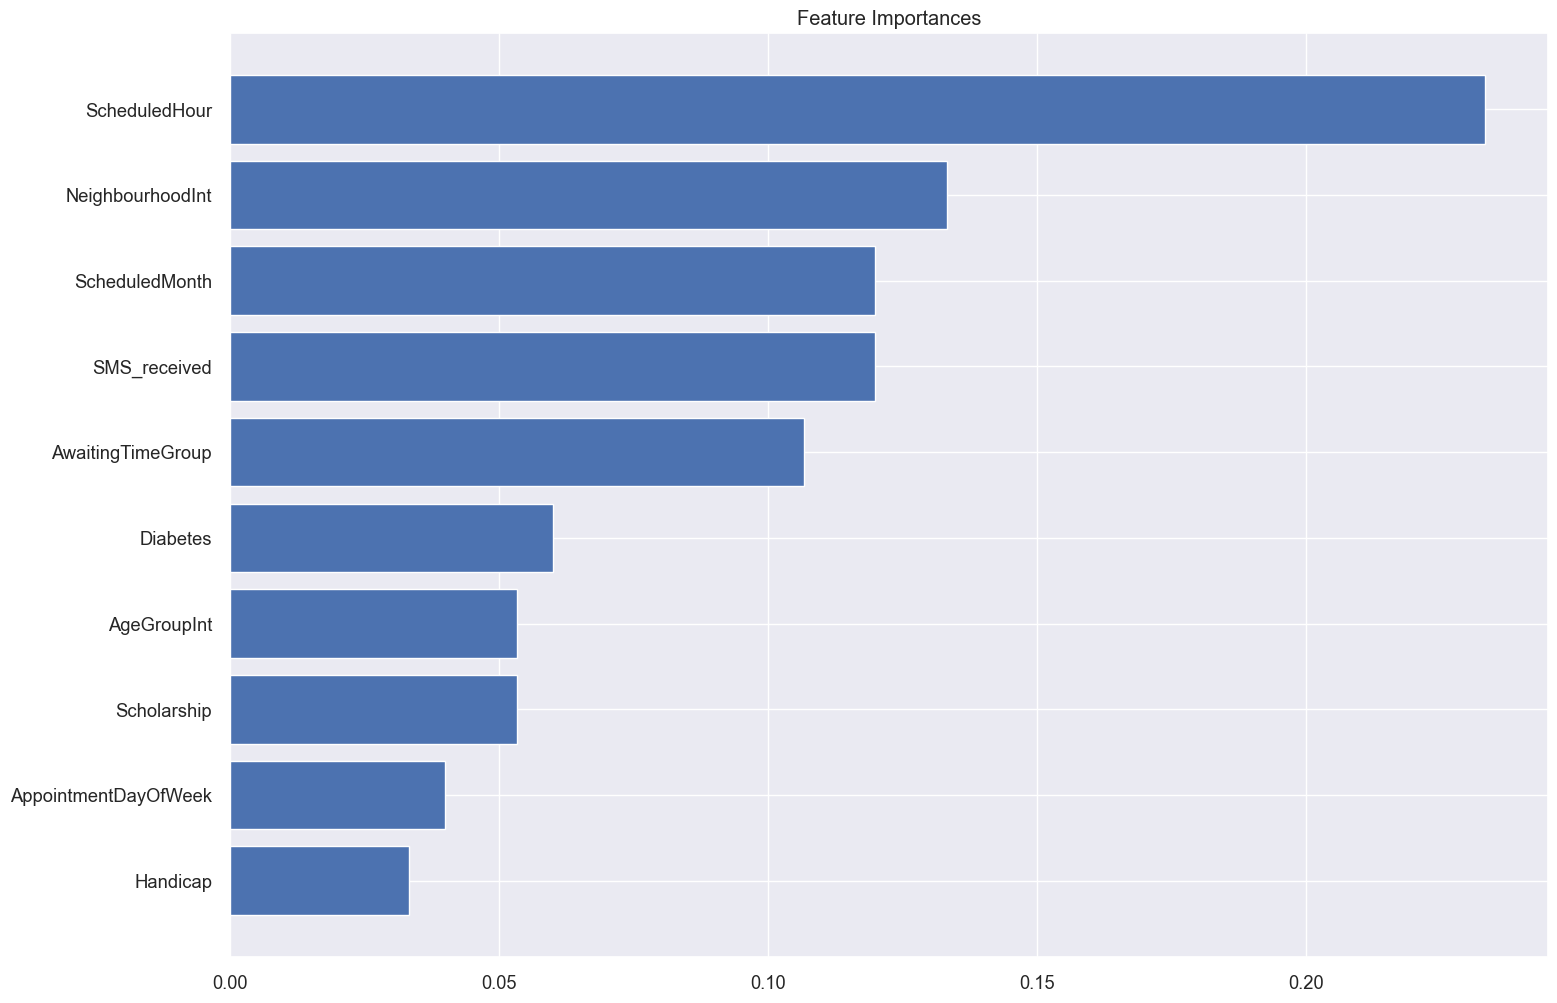

In [76]:
importances_ada = adaboost_cls.feature_importances_
plt.figure(figsize=(17, 12))
sns.set(font_scale=1.2)
indices = np.argsort(importances_ada)[-10:]
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_ada[indices], color='b', align='center')
plt.yticks(range(len(indices)), X.columns[indices])
plt.show()

#### Partial Dependence Plots (PDPs)

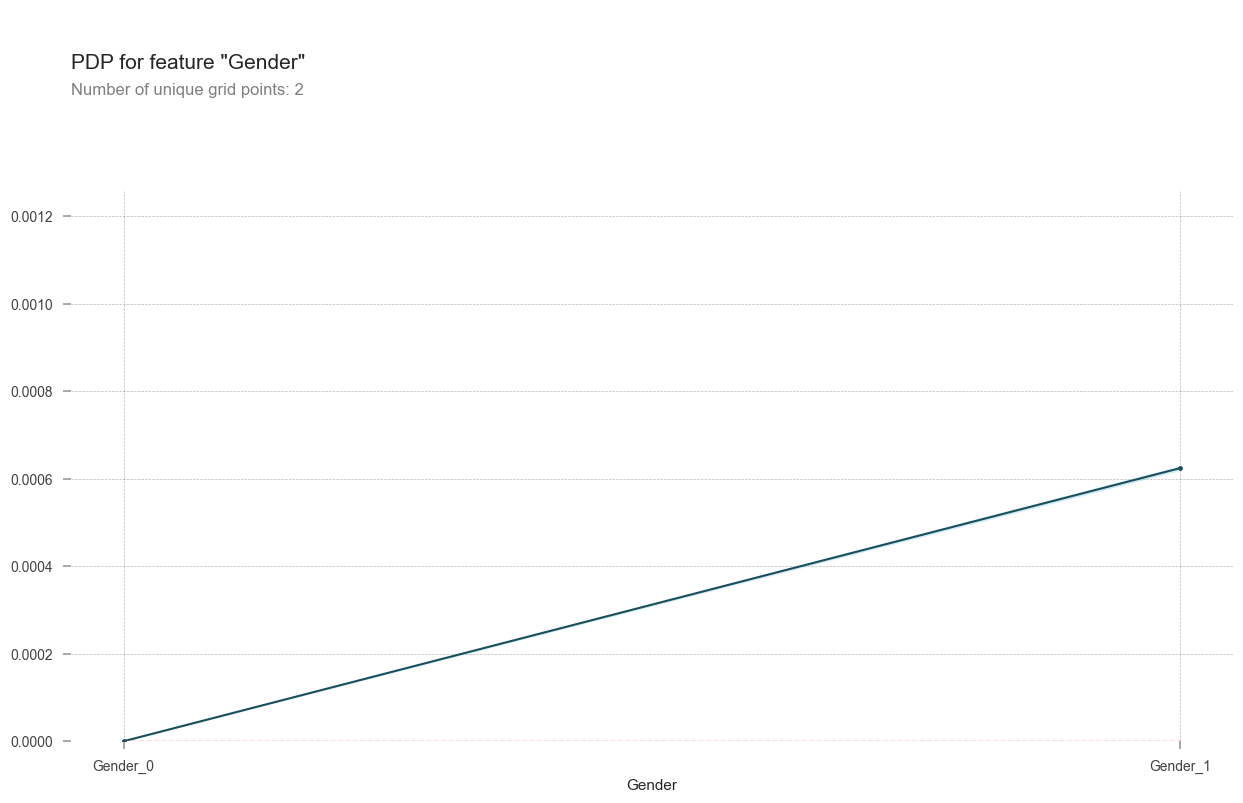

In [77]:
pdp_dist = pdp.pdp_isolate(model=adaboost_cls, dataset=X, model_features=X.columns, feature='Gender')
pdp.pdp_plot(pdp_dist, 'Gender')
plt.show()

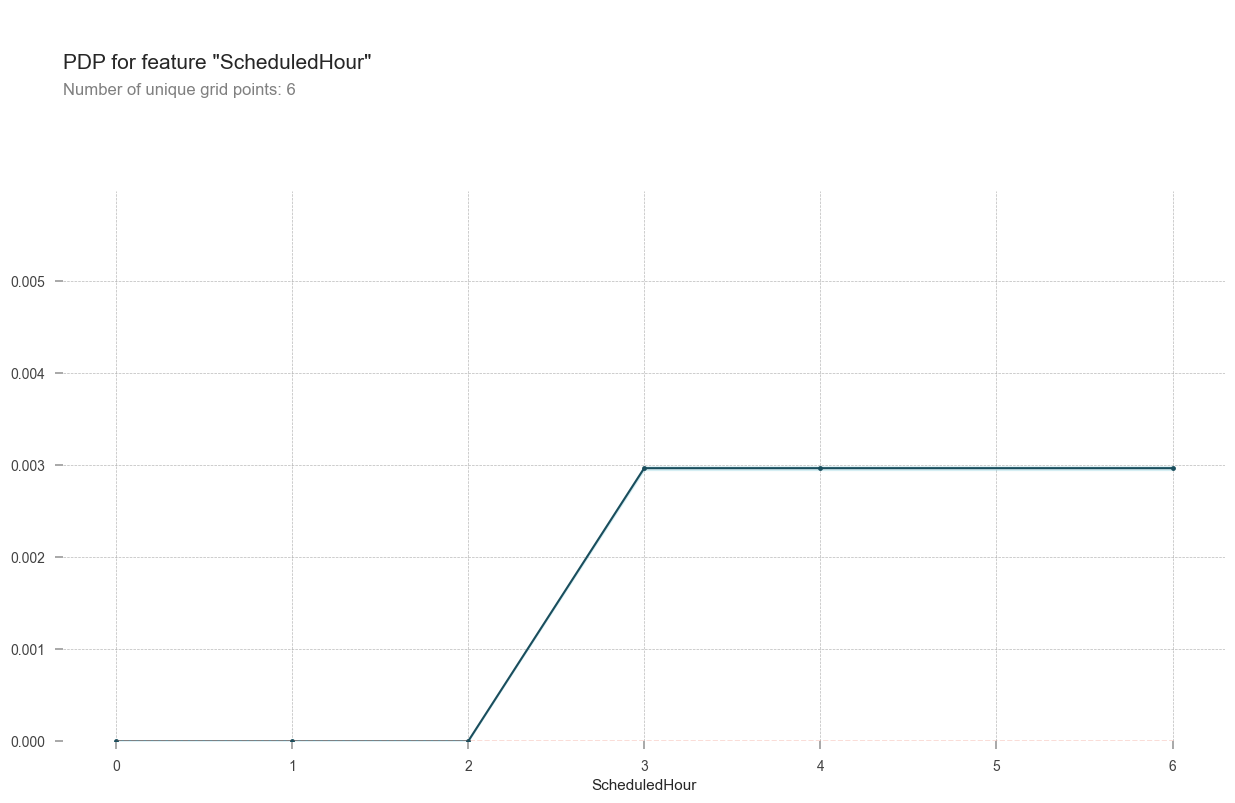

In [84]:
pdp_dist = pdp.pdp_isolate(model=adaboost_cls, dataset=X, model_features=X.columns, feature='AgeGroupInt')
pdp.pdp_plot(pdp_dist, 'ScheduledHour')
plt.show()

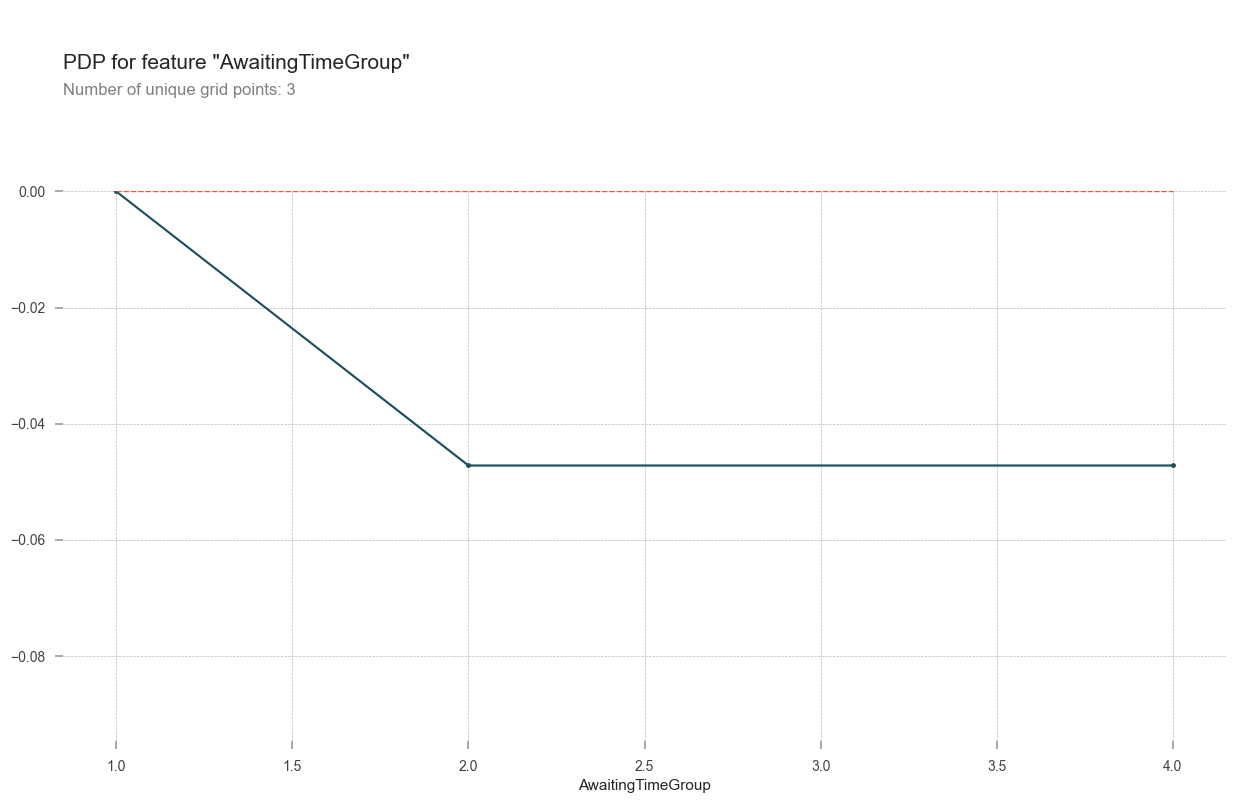

In [79]:
pdp_dist = pdp.pdp_isolate(
    model=adaboost_cls, 
    dataset=X, 
    model_features=X.columns, 
    feature='AwaitingTimeGroup'
)
pdp.pdp_plot(pdp_dist, 'AwaitingTimeGroup')
plt.show()

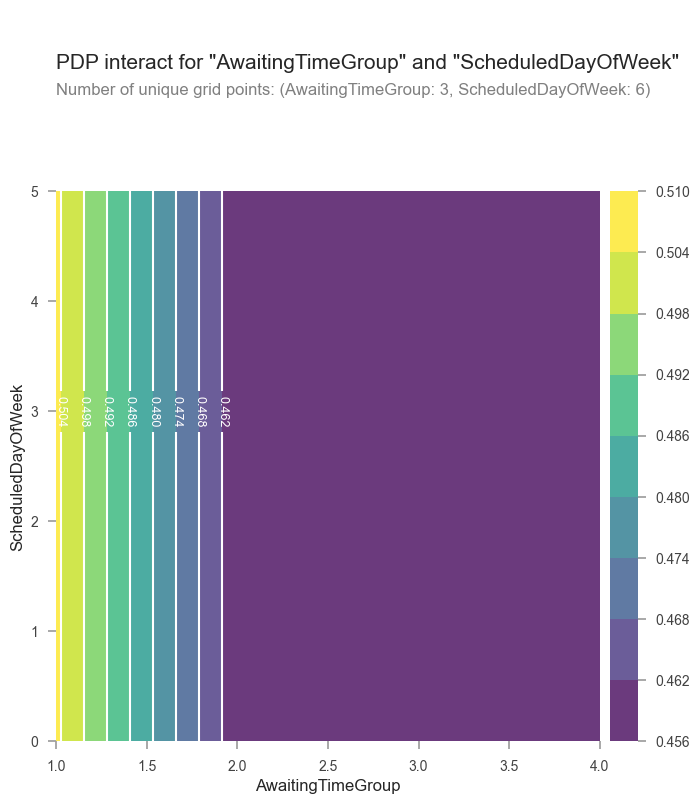

In [80]:
pdp_dist = pdp.pdp_interact(model=adaboost_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'ScheduledDayOfWeek'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'ScheduledDayOfWeek'], plot_type='contour')
plt.show()

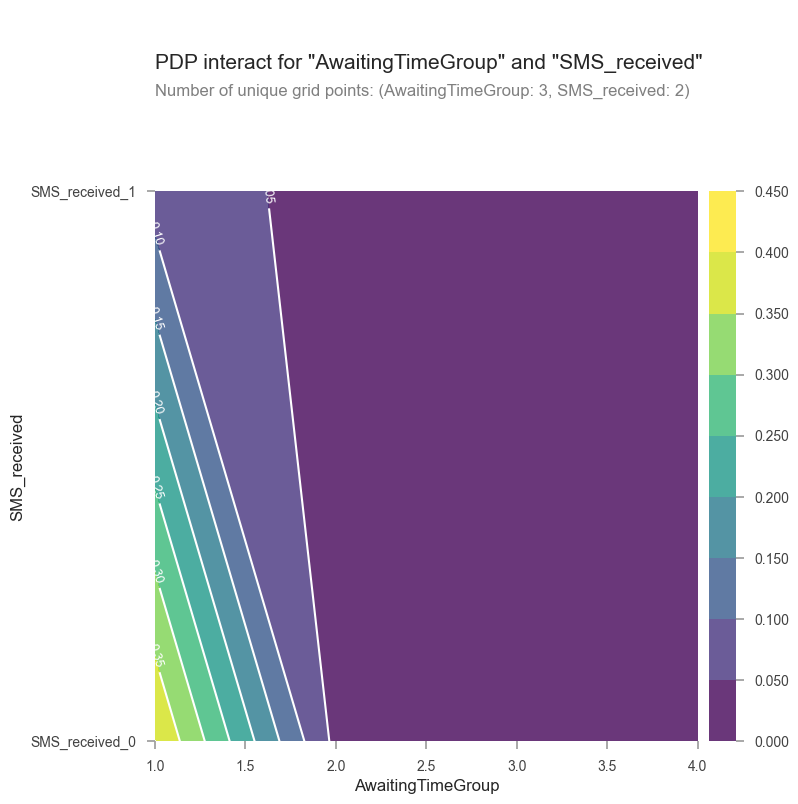

In [ ]:
pdp_dist = pdp.pdp_interact(model=adaboost_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'SMS_received'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'SMS_received'], plot_type='contour')
plt.show()

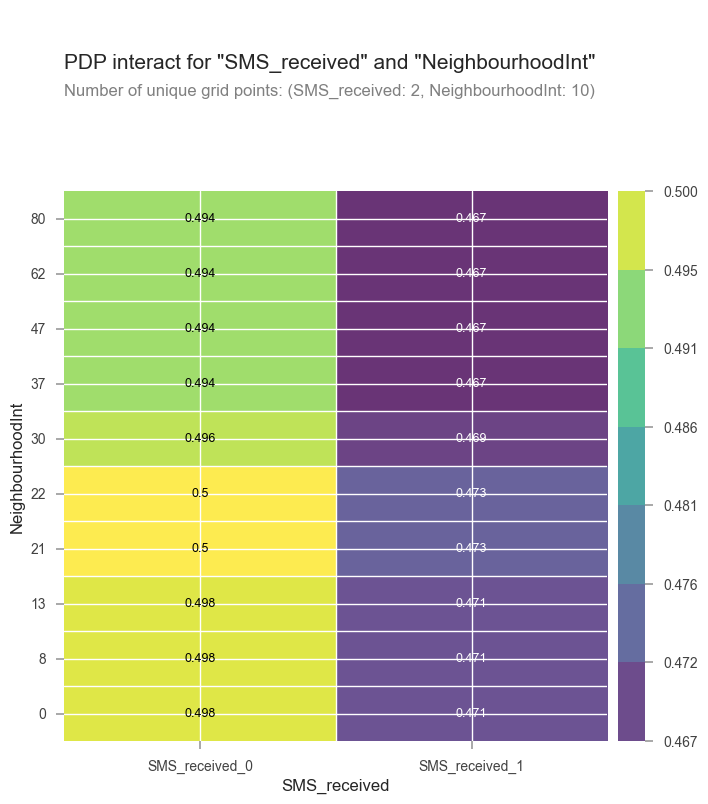

In [81]:
pdp_dist = pdp.pdp_interact(model=adaboost_cls, dataset=X, model_features=X.columns, features=['SMS_received', 'NeighbourhoodInt'])
pdp.pdp_interact_plot(pdp_dist, ['SMS_received', 'NeighbourhoodInt'], plot_type='grid')
plt.show()

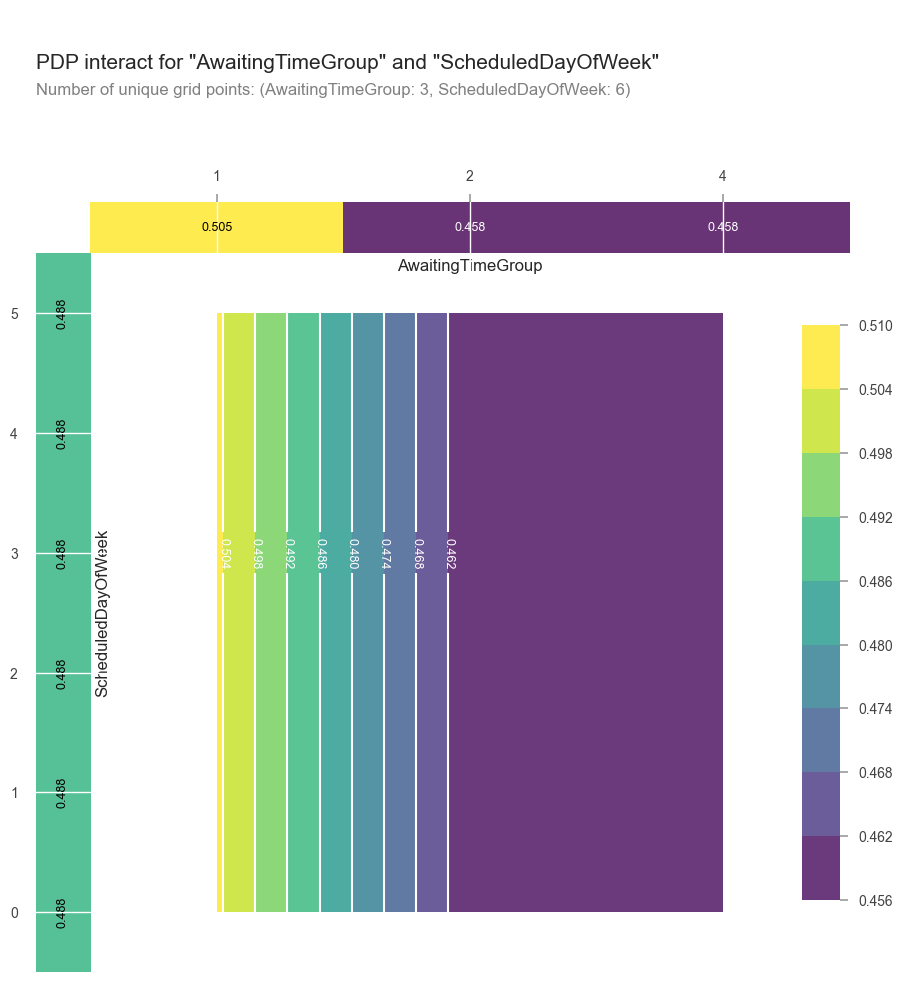

In [82]:
pdp_dist = pdp.pdp_interact(model=adaboost_cls, dataset=X, model_features=X.columns, features=['AwaitingTimeGroup', 'ScheduledDayOfWeek'])
pdp.pdp_interact_plot(pdp_dist, ['AwaitingTimeGroup', 'ScheduledDayOfWeek'], plot_type='contour', plot_pdp=True)
plt.show()

#### Individual Conditional Expectation (ICE)


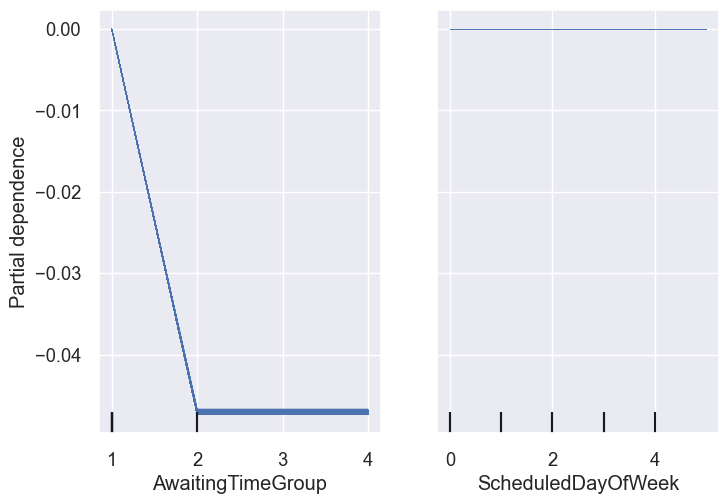

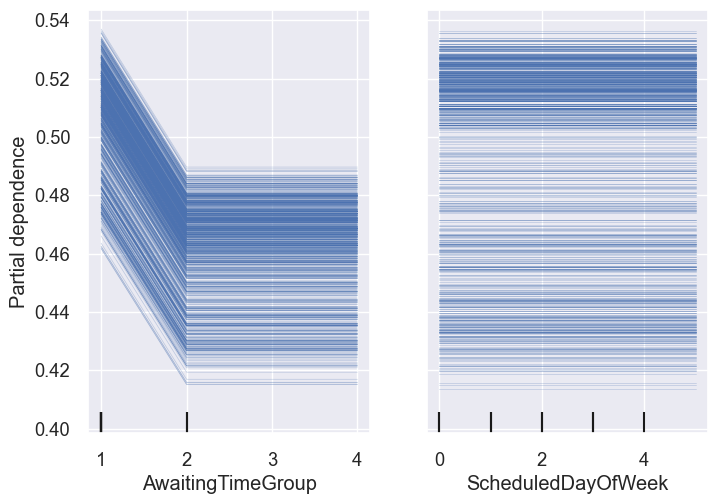

In [83]:
PartialDependenceDisplay.from_estimator(
    adaboost_cls,
    X_res,
    features=['AwaitingTimeGroup', 'ScheduledDayOfWeek'],
    kind='individual',
    centered=True,
    subsample=1000,
).plot()

In [45]:
lime = LimeTabular(
    model=adaboost_cls,
    data=X_train,
    random_state=1
)

lime_local = lime.explain_local(
    X_test[1400:1402],
    y_test[1400:1402],
    name='LIME'
)

show(lime_local)  

<!-- http://127.0.0.1:7001/12400598944/ -->

#### SHAP

In [ ]:
explainer = shap.Explainer(adaboost_cls)
shap_values = explainer(X_test)

shap.plots.bar(shap_values)